# HR-Capstone-Analysis

# Imports

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier


# Functions

In [120]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def plot_distribution(df, kind):
  
  plt.figure(figsize=(16,16))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(df.columns):
    if col == "Type":
      continue
    plt.subplot(rows ,4, idx+1)
    sns.histplot(df[col], kde=True) if kind == "hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")

  plt.tight_layout()
  plt.show()

def dist_plot(df):
  
  for col in df.columns:
    salary_skewness = df[col].skew()
    salary_kurtosis = df[col].kurtosis()

    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution of {col} with Skewness and Kurtosis')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.text(x=0.95, y=0.85, s=f"Skewness: {salary_skewness:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')
    plt.text(x=0.95, y=0.80, s=f"Kurtosis: {salary_kurtosis:.2f}", transform=plt.gca().transAxes, horizontalalignment='right')

    plt.grid(True)
    plt.show()

def aggregate_dataset(df, interested_columns, agg_col, function):
  
  plt.figure(figsize=(12,12))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == agg_col:
      continue
    plt.subplot(rows ,4, idx+1)
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
  plt.tight_layout()
  plt.show()

def scatter_plot(df, interested_columns, target):
  
  plt.figure(figsize=(12,10))
  columns = len(df.columns)
  rows = (columns + 3) //4
  
  for idx, col in enumerate(interested_columns):
    if col == target:
      continue
    plt.subplot(rows ,3, idx+1)
    sns.scatterplot(data=df, x=target, y=col, hue=col)
  plt.tight_layout()
  plt.show()

def aggregate_salaries(df):
  
  department_columns = df["Department"].unique()

  metric_tracker = []
  for col in department_columns:
    row = df[df["Department"] == col]
    
    avg_monthly_hours =  row["average_montly_hours"].mean()
    total_hours = row["average_montly_hours"].sum()
    
    total_turnover = row["left"].sum()
    percentage_left = row["left"].mean()  * 100
    
    num_work_accidents = row["Work_accident"].sum()
    percentage_work_accidents = row["Work_accident"].mean() * 100
    
    num_promotions = row["promotion_last_5years"].sum()
    mean_promotions = row["promotion_last_5years"].mean()
    
    mean_years_at_company = row["time_spend_company"].mean()
    sum_years_at_company = row["time_spend_company"].sum()
    
    mean_projects= row["number_project"].mean()
    sum_projects = row["number_project"].sum()
    
    mean_satisfaction_level = row["satisfaction_level"].mean()
    total_satisfaction_level = row["satisfaction_level"].sum()
    
    mean_evaluation = row["last_evaluation"].mean()
    sum_evaluation = row["last_evaluation"].sum()
    
    metric_tracker.append(
      {
        "department":col,
        "avg_monhtly_hours": avg_monthly_hours,
        "total_hours": total_hours,
        "total_turnover":total_turnover,
        "percentage_left":percentage_left,
        "num_work_accidents":num_work_accidents,
        "percentage_work_accidents":percentage_work_accidents,
        "num_promotions": num_promotions,
        "mean_promotions":mean_promotions,
        "mean_years_at_company":mean_years_at_company,
        "sum_years_at_company":sum_years_at_company,
        "mean_projects":mean_projects,
        "sum_projects":sum_projects,
        "mean_statisfaction_level":mean_satisfaction_level,
        "total_satisfaction_level":total_satisfaction_level,
        "mean_evaluation":mean_evaluation,
        "sum_evaluation":sum_evaluation
      }
    )
  
  return pd.DataFrame(metric_tracker)

def insert_columns(df, stats_df, salary_range):
  
  for col in df["Department"].unique():
    row = stats_df[stats_df["department"] == col]
    if not row.empty:
            idx = row.index[0]
            
            mask = (df['Department'] == col) & (df['salary'] == salary_range)
            df.loc[mask, 'percentage_left'] = row.at[idx, 'percentage_left']
            df.loc[mask, 'percentage_work_accidents'] = row.at[idx, 'percentage_work_accidents']
            df.loc[mask, 'mean_promotions'] = row.at[idx, 'mean_promotions']
            df.loc[mask, 'mean_years_at_company'] = row.at[idx, 'mean_years_at_company']
            df.loc[mask, 'mean_projects'] = row.at[idx, 'mean_projects']
            df.loc[mask, 'mean_statisfaction_level'] = row.at[idx, 'mean_statisfaction_level']
  
  return df

def create_column_transformer(cat_cols, numeric_cols):
  
  cat_transformer = Pipeline(
    steps=[
      ("encoder", OneHotEncoder())
    ]
  )
  
  numeric_transformer = Pipeline(
    steps =[
      ("scaler", StandardScaler()),
      ("PowerTransformer", PowerTransformer())
    ]
  )
  
  return ColumnTransformer(
    transformers=[
      ("cat", cat_transformer, cat_cols),
      ("numeric", numeric_transformer, numeric_cols)
    ]
  )

def create_sklearn_pipeline(preprocessor,model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(1, ("Feature Selection", kbest))
  
  return sklearnPipeline(steps=steps)

def create_sampling_pipeline(preprocessor, sampling_model, model, kbest=None):
  
  steps = [
    ("preprocessor", preprocessor),
    ("sample", sampling_model),
    ("model", model)
  ]
  
  if kbest:
    steps.insert(2, ("Feature Selection", kbest))
  
  return Pipeline(steps=steps)

def pca_analysis(X, preprocessor):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(preprocessor, pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(14, 10))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  return performance_df

def plot_confusion_matrix(y_true, y_pred, model_name):
  
  plt.figure(figsize=(10, 7))
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(data=cm, annot=True, fmt="d", cmap="Blues")
  plt.title(f"Confusion Matrix For: {model_name}")
  plt.ylabel("Predicted Labels")
  plt.xlabel("True Labels")
  plt.show()

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "CAT": CatBoostClassifier(),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]
def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_selected_models(preprocessor, model_names, models, X, y, scoring_metric, sample_model=None, kbest=None):
  means, variances, std_devs, test_accs, recalls, precisions, f1_scores = [], [], [], [], [], [], []
  metric_tracker = []
  for model, model_name in zip(models, model_names):
    if kbest:
        pipeline = create_sampling_pipeline(preprocessor, sample_model, model, kbest)
    else:
        pipeline = create_sklearn_pipeline(preprocessor, model)
    
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
    
    means.append(scores[0])
    variances.append(scores[1])
    std_devs.append(scores[2])
    test_accs.append(scores[3])
    recalls.append(scores[4])
    precisions.append(scores[5])
    f1_scores.append(scores[6])
    
  plt.figure(figsize=(12, 8))
  models_index = range(len(model_names)) 
  plt.plot(models_index, means, marker='o', label='Mean')
  plt.plot(models_index, test_accs, marker='^', label='Test Accuracy')
  plt.plot(models_index, f1_scores, marker='s', label='F1 Score')
  plt.xticks(models_index, model_names, rotation=45) 
  plt.xlabel('Models')
  plt.ylabel('Scores')
  plt.title('Comparison of Model Performance')
  plt.legend()
  plt.grid(True)
  plt.show()
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  return performance_df

def test_kbest_columns(preprocessor, X, y, sample_model, model, model_name, kbest):
  acc_scores = []
  f1_scores = []
  recall_scores = []
  precision_scores = []
  ks = []
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_sampling_pipeline(preprocessor, sample_model, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
    
    all_transformed_features = pipeline.named_steps['preprocessor'].get_feature_names_out()
    selected_mask = pipeline.named_steps["Feature Selection"].get_support()
    selected_features = all_transformed_features[selected_mask]
    
    cleaned_features = [col.replace("numeric__", "").replace("cat__", "") for col in selected_features]

    ks.append(k)
    acc_scores.append(acc)
    f1_scores.append(f1_metric)
    recall_scores.append(recall_metric)
    precision_scores.append(precision_metric)
    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "Selected Featured":", ".join(cleaned_features),
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  plt.figure(figsize=(10, 8))
  plt.plot(ks, acc_scores, marker='o', label='Accuracy')
  plt.plot(ks, f1_scores, marker='o', label='F1 Score')
  plt.plot(ks, recall_scores, marker='o', label='Recall')
  plt.plot(ks, precision_scores, marker='o', label='Precision')
  plt.xlabel('Number of Features Selected (k)')
  plt.ylabel('Score')
  plt.title('Model Performance Metrics vs. Number of Features')
  plt.legend()
  plt.grid(True)
  plt.show()
  return pd.DataFrame(metric_tracker)

def optimization_search(preprocessor, sample_model, model_names, models,X, y, optimizer_class, param_distributions, scoring_metric, kbest):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  metric_tracker = []
  
  for model_name, model in zip(model_names, models):
    model_pipeline = create_sampling_pipeline(preprocessor,sample_model, model, kbest)
    current_params = param_distributions.get(model_name, {})
    opt_search= optimizer_class(model_pipeline, param_distributions=current_params, cv=15, scoring=scoring_metric, n_jobs=-1)
    opt_search.fit(X_train, y_train)
    
    best_model = opt_search.best_estimator_
    best_params = opt_search.best_params_
    y_pred = best_model.predict(X_test)
    
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)
      
    plot_confusion_matrix(y_test, y_pred, model_name)
    print(f"The Best Param: {best_params}")
    metric_tracker.append({
        "Model": model_name,
        "Test-Acc":acc,
        "F1-Score":f1_metric,
        "recall-Score":recall_metric,
        "precision-Score":precision_metric,
      })
  
  return pd.DataFrame(metric_tracker).sort_values(by="F1-Score", ascending=False)

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/data.csv")
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


# Check For Nulls And Dupes

In [4]:
check_for_nulls_dupes(df)

The amount of Null Values: satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64
The amount of Duplicated Values 3008


In [5]:
df.drop_duplicates(inplace=True)

# Check Class Imbalance

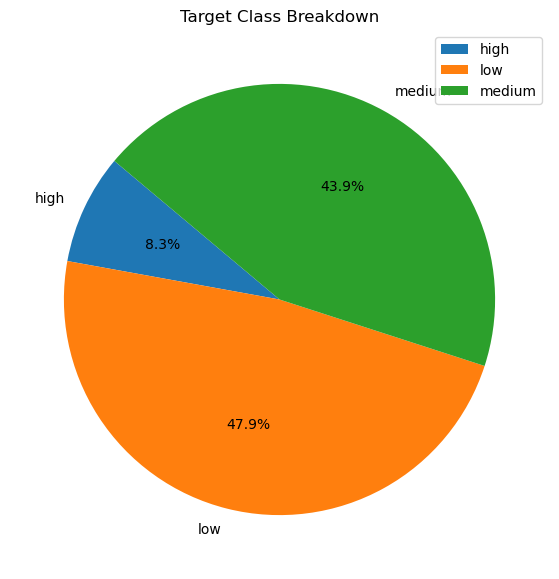

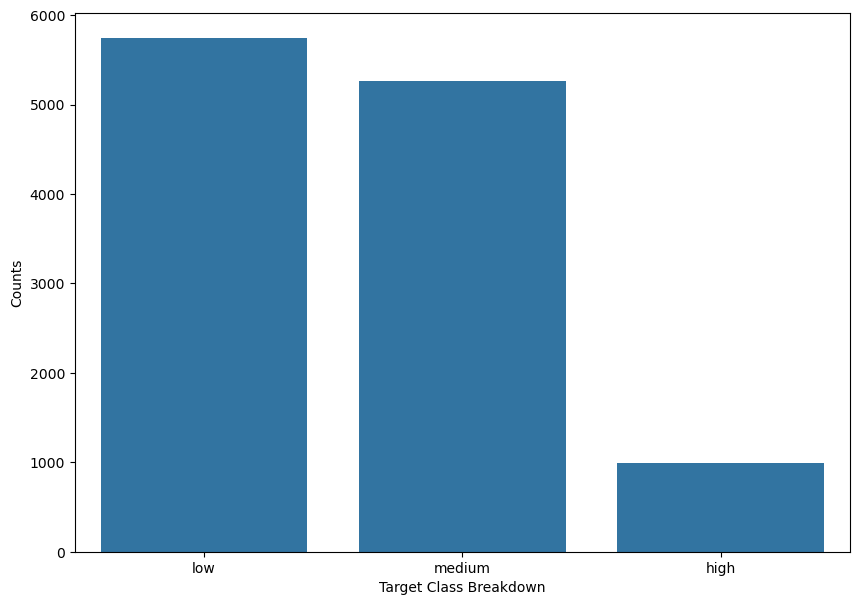

In [6]:
check_class_imbalance(df["salary"])

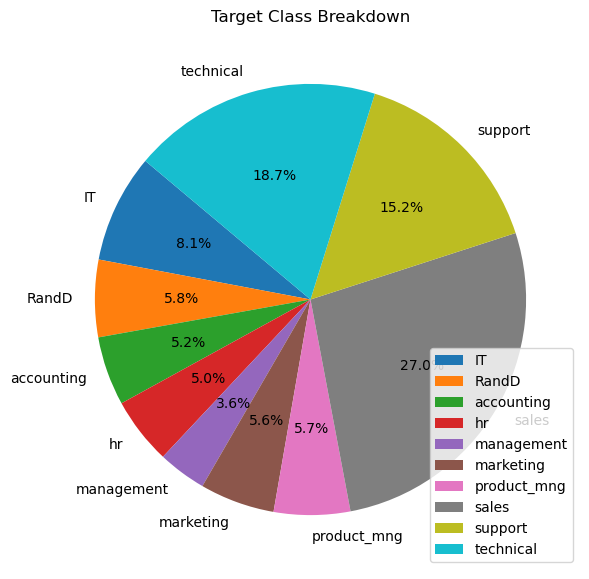

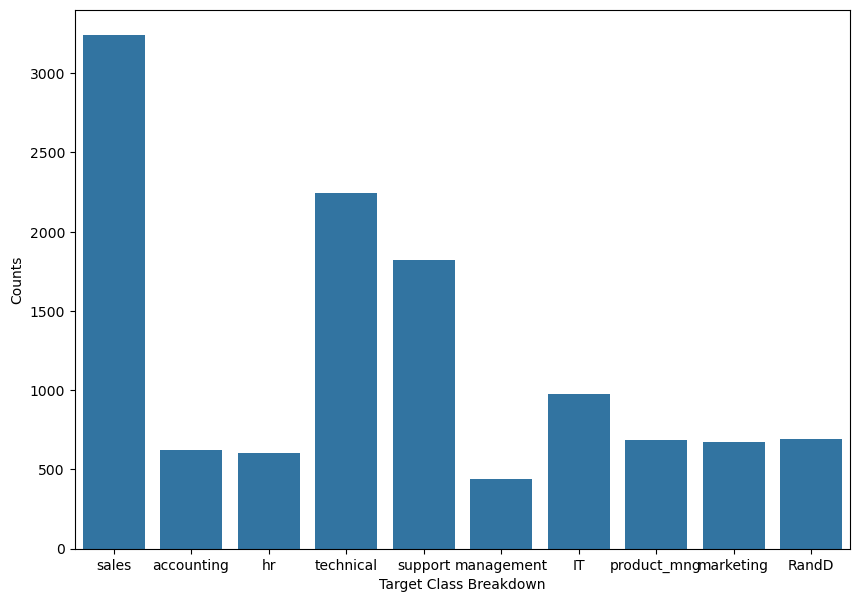

In [7]:
check_class_imbalance(df["Department"])

In [8]:
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857,0.154282,0.166041,0.016929
std,0.241070,0.168343,1.163238,48.727813,1.330240,0.361234,0.372133,0.129012
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [10]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
Department                object
salary                    object
dtype: object

In [9]:
numeric_types = df.select_dtypes(exclude=["object"])
categorical_types = df.select_dtypes(include=["object"])

In [12]:
heat_map_df = df.copy()
heat_map_df["salary"] = heat_map_df["salary"].apply(lambda x: 0 if x == "low" else 1 if x == "medium" else 2)

# Heat Map

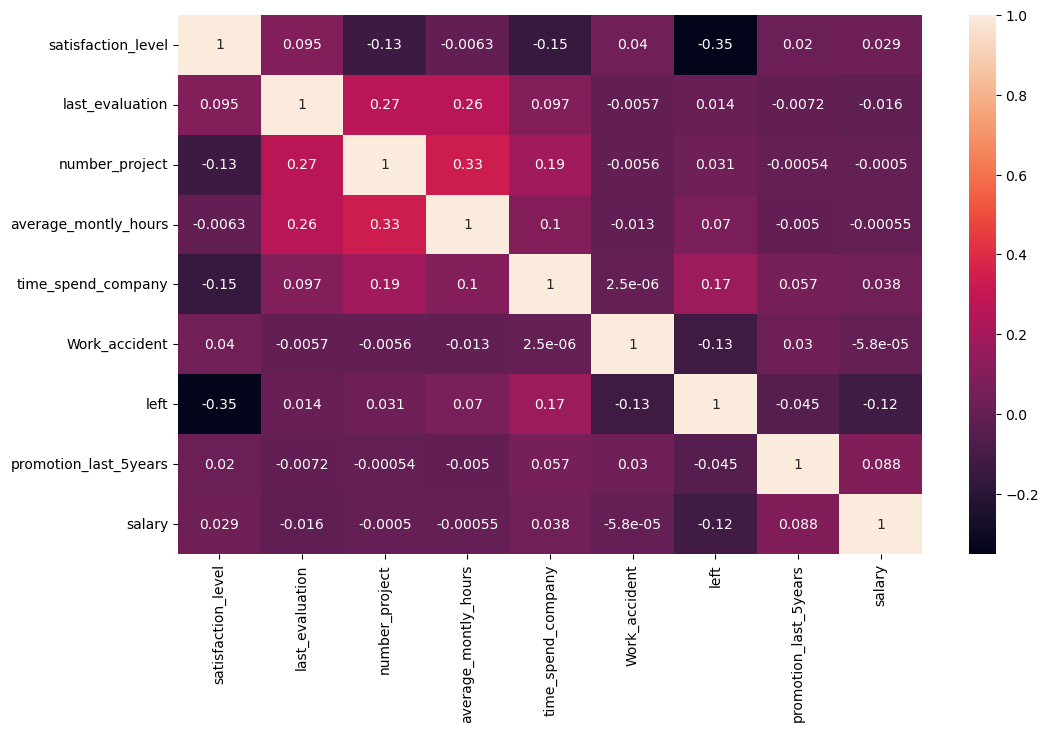

In [13]:
relations = heat_map_df.select_dtypes(exclude="object").corr()
plt.figure(figsize=(12, 7))
sns.heatmap(data=relations, annot=True)
plt.show()

# Distributions

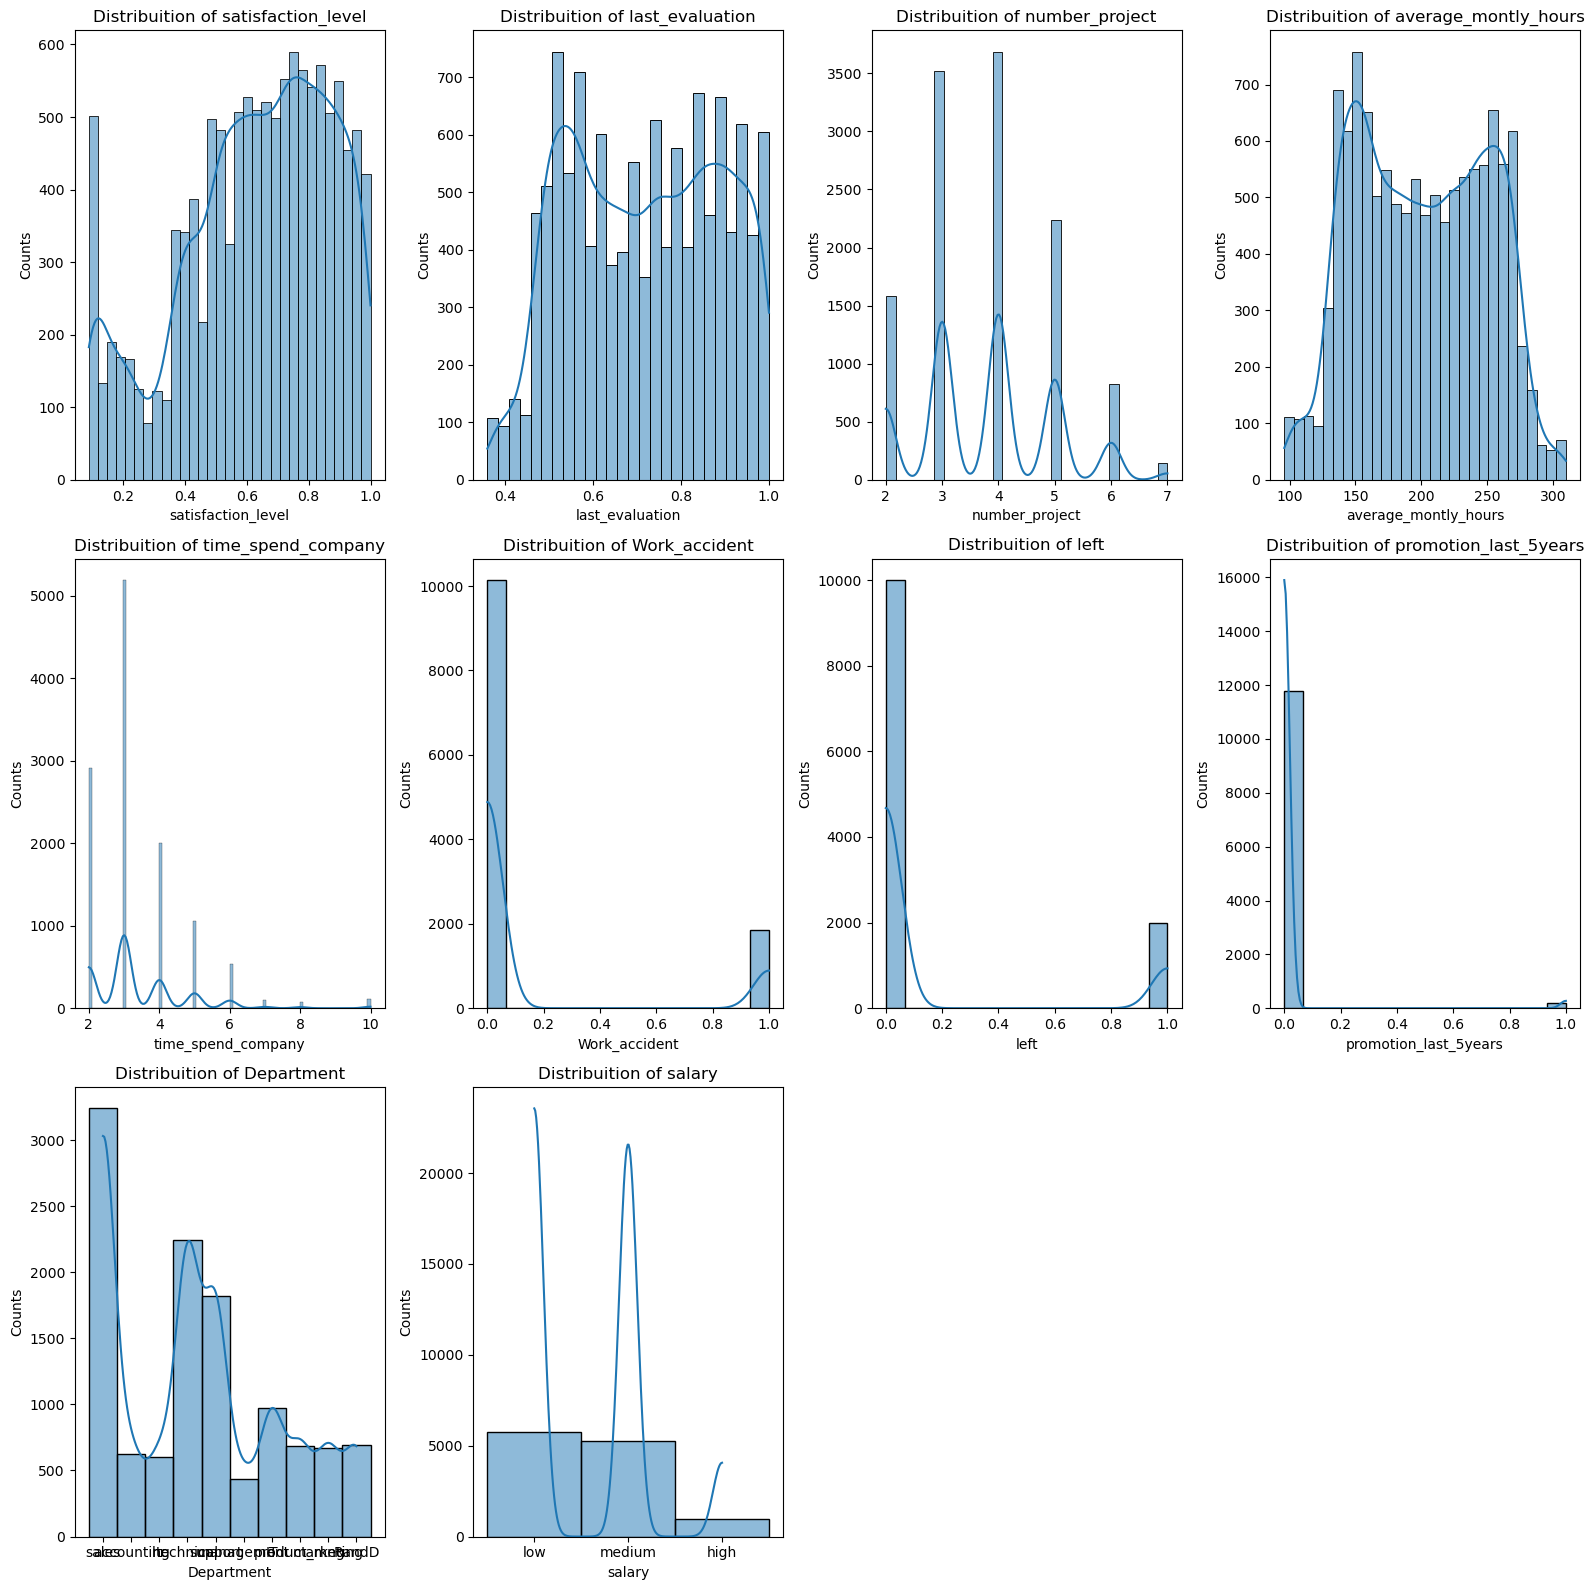

In [15]:
plot_distribution(df, "hist")

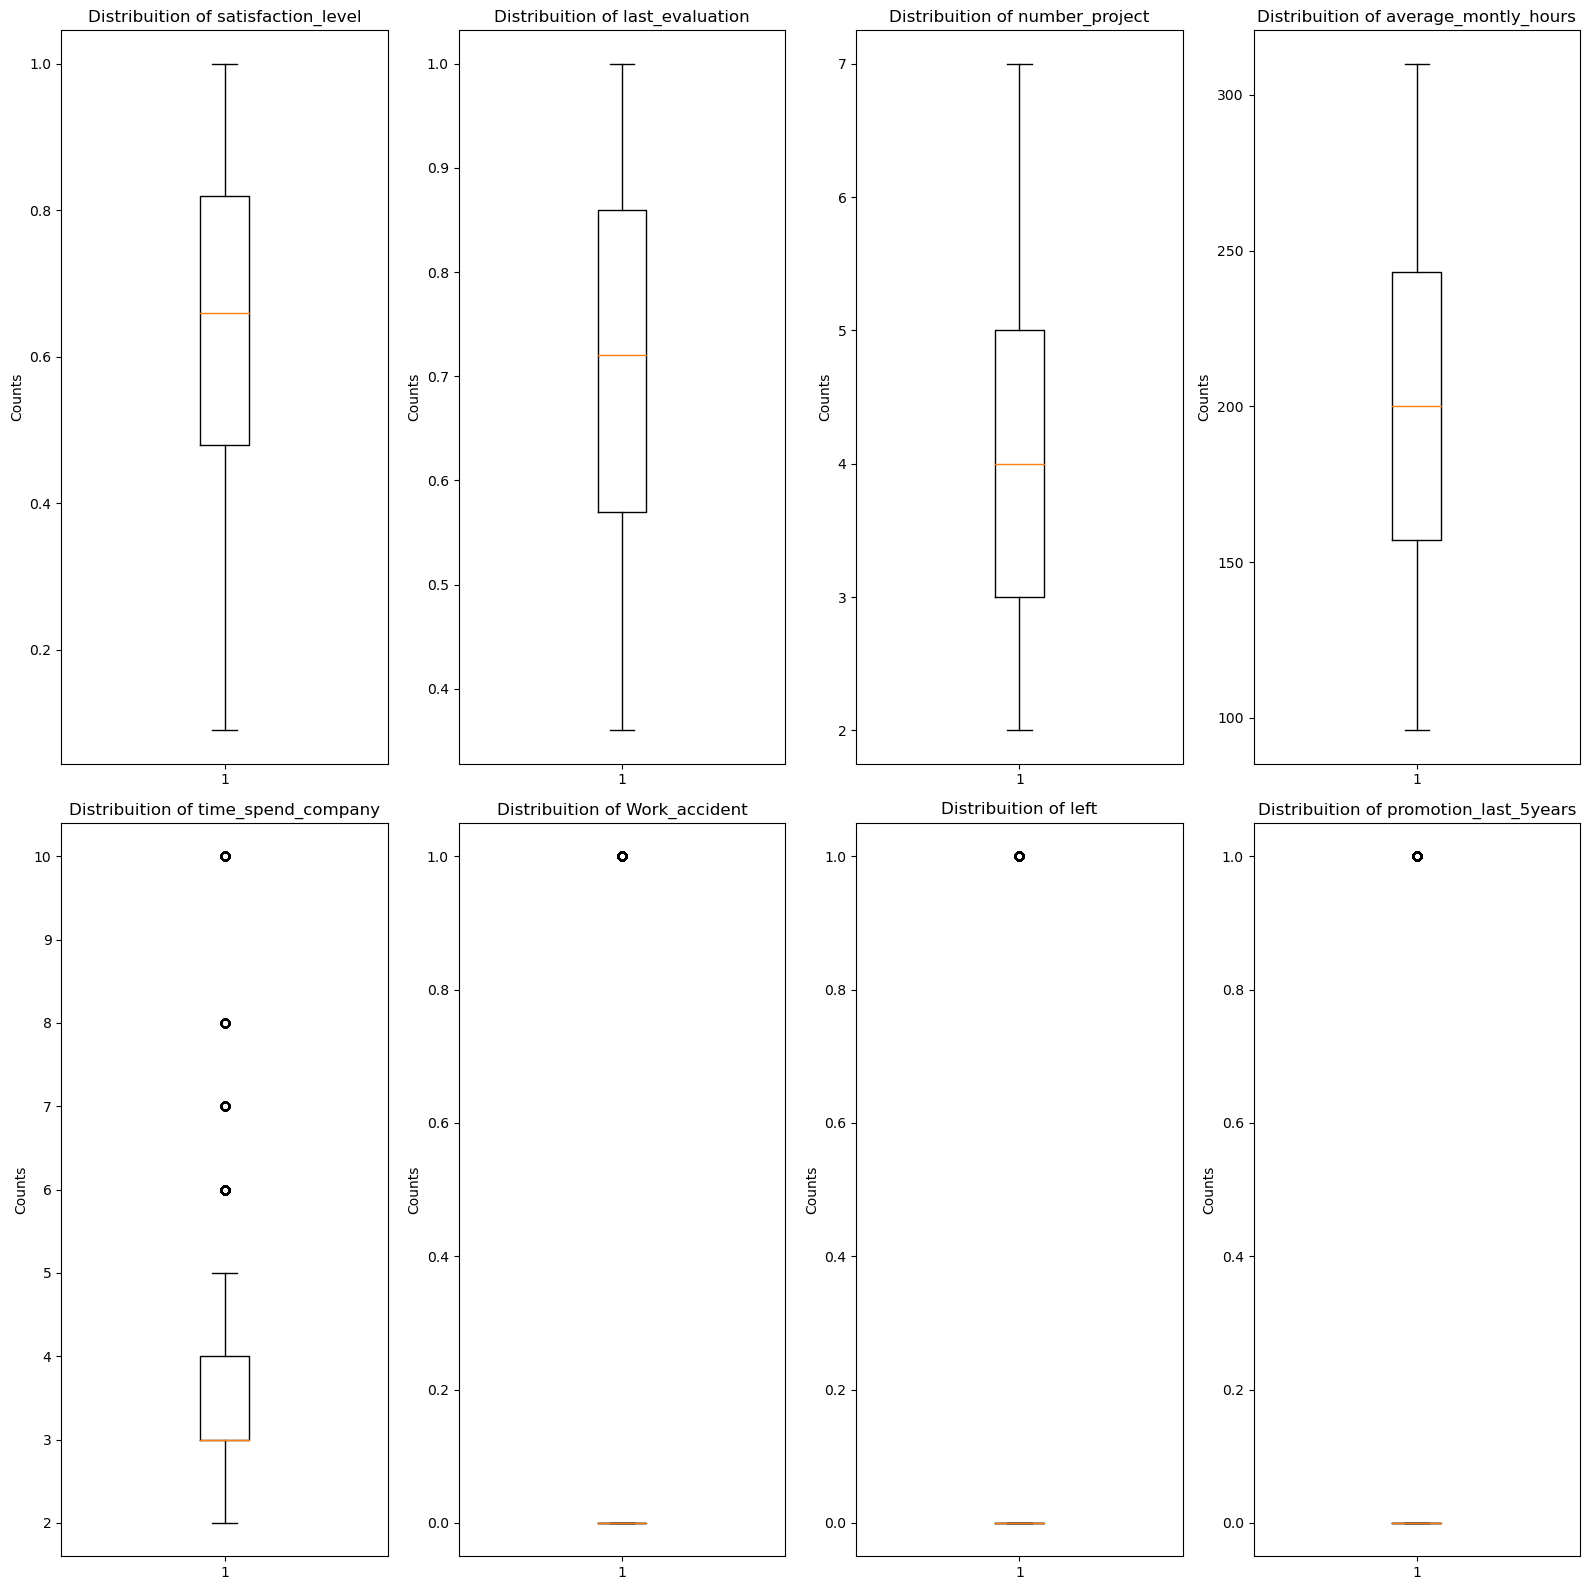

In [17]:
plot_distribution(numeric_types, "box")

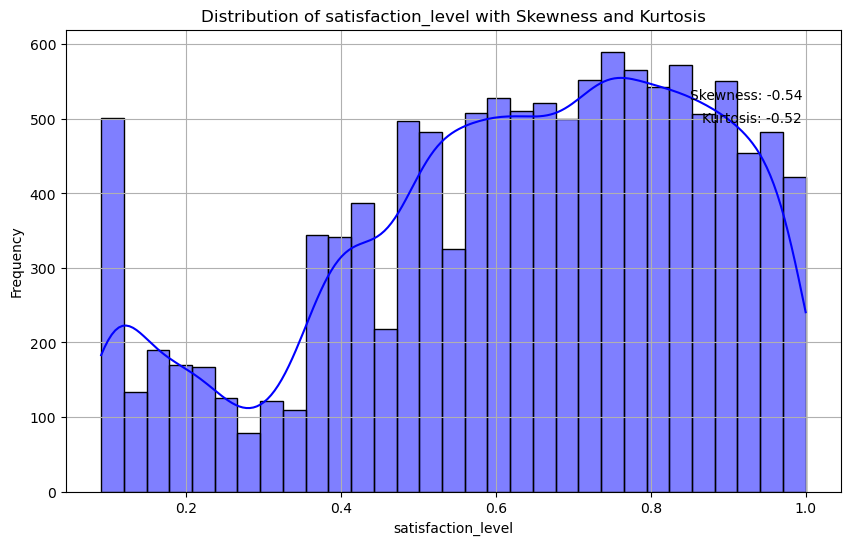

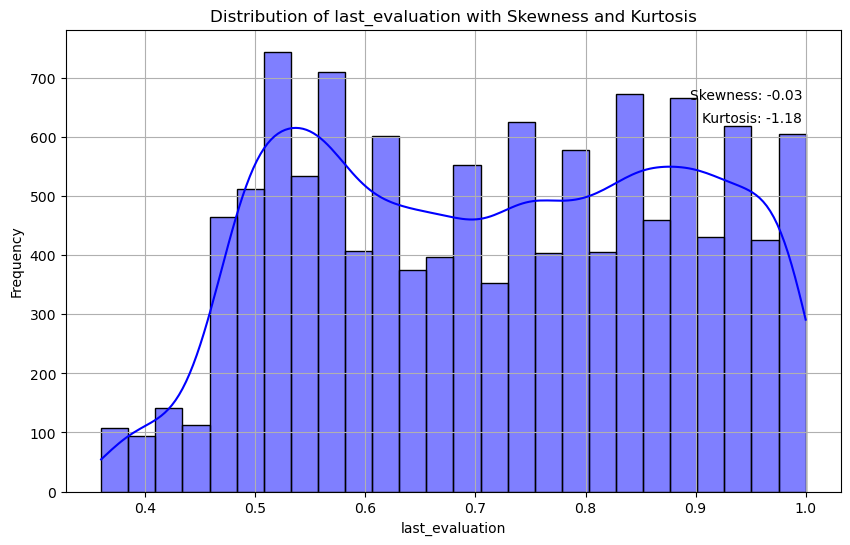

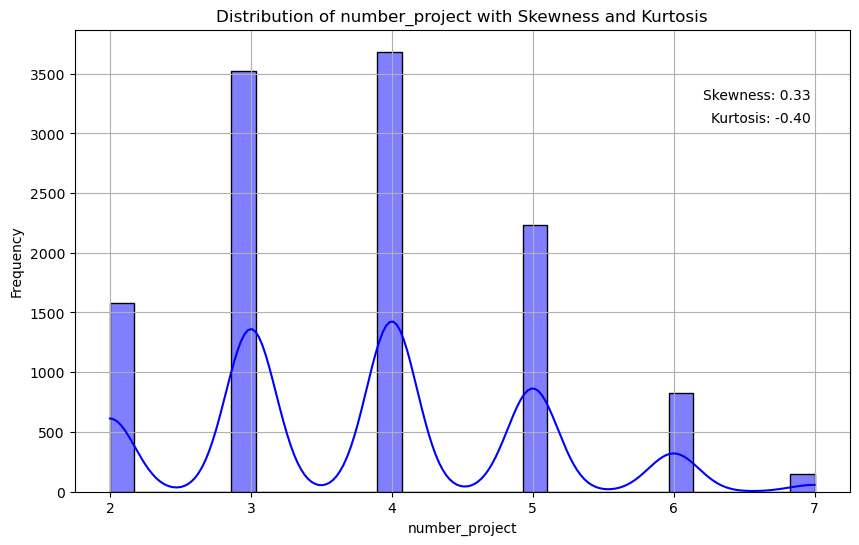

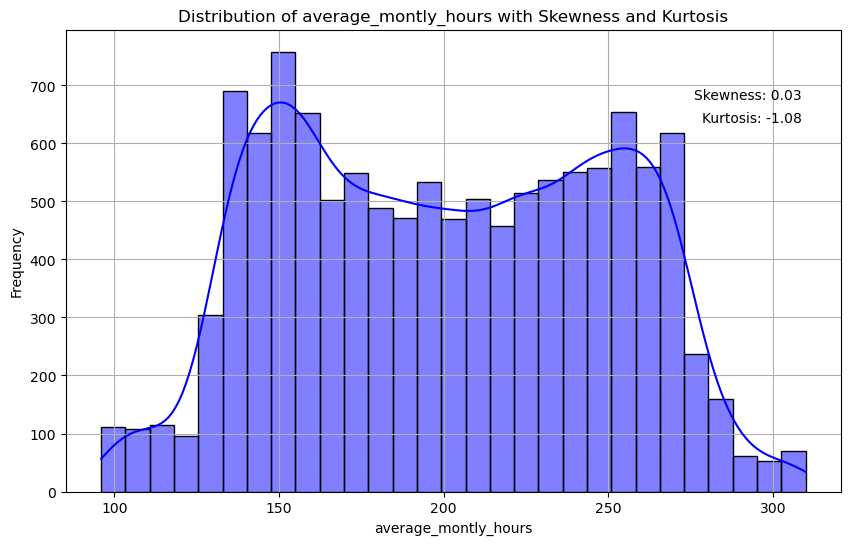

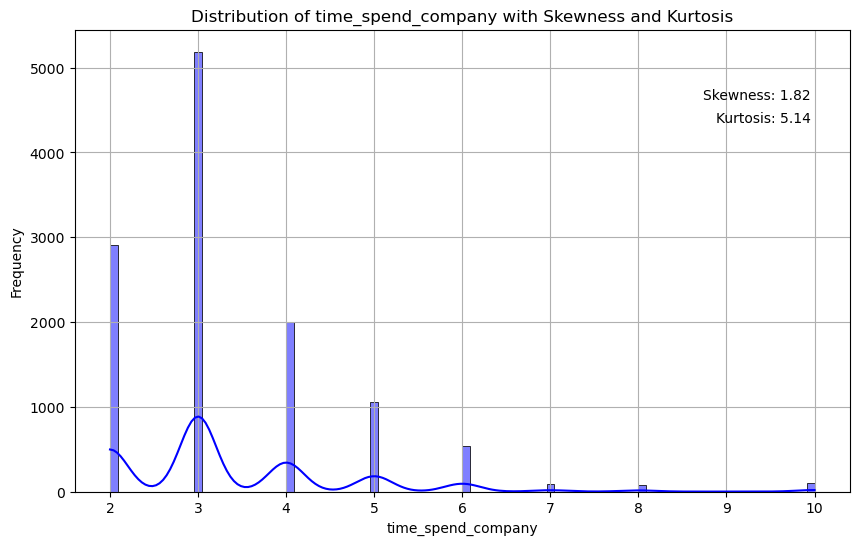

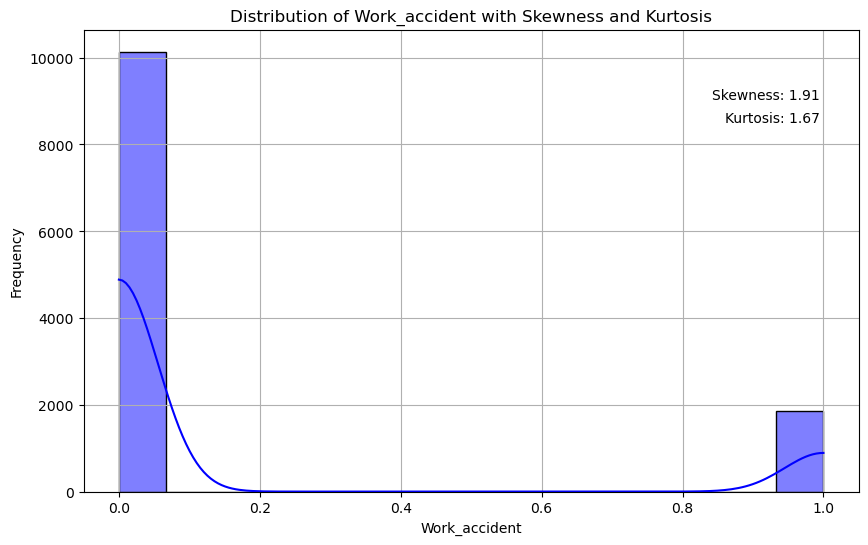

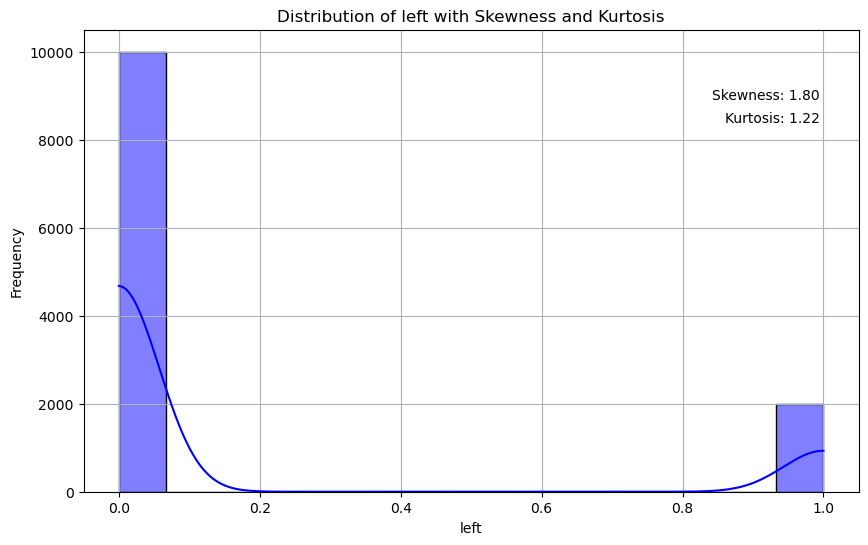

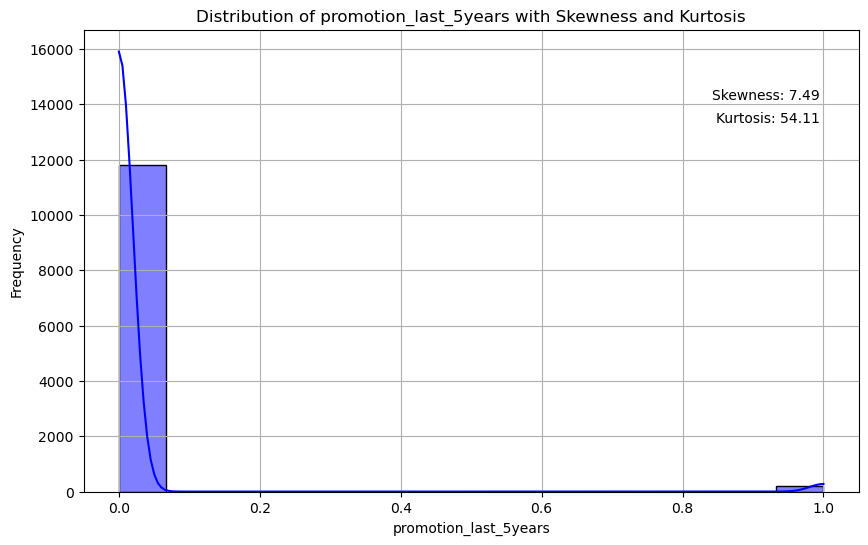

In [19]:
dist_plot(numeric_types)

# Aggregated Views

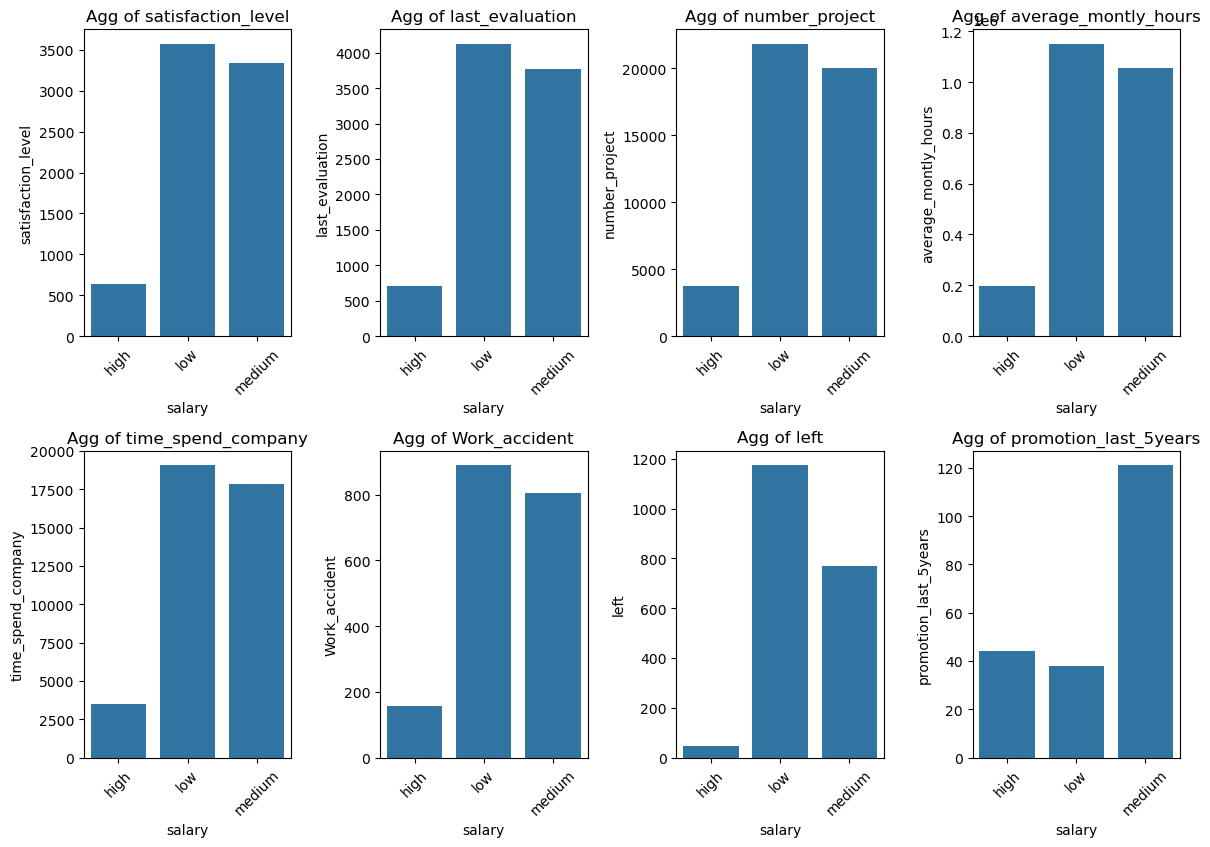

In [22]:
aggregate_dataset(df, numeric_types.columns, "salary", "sum")

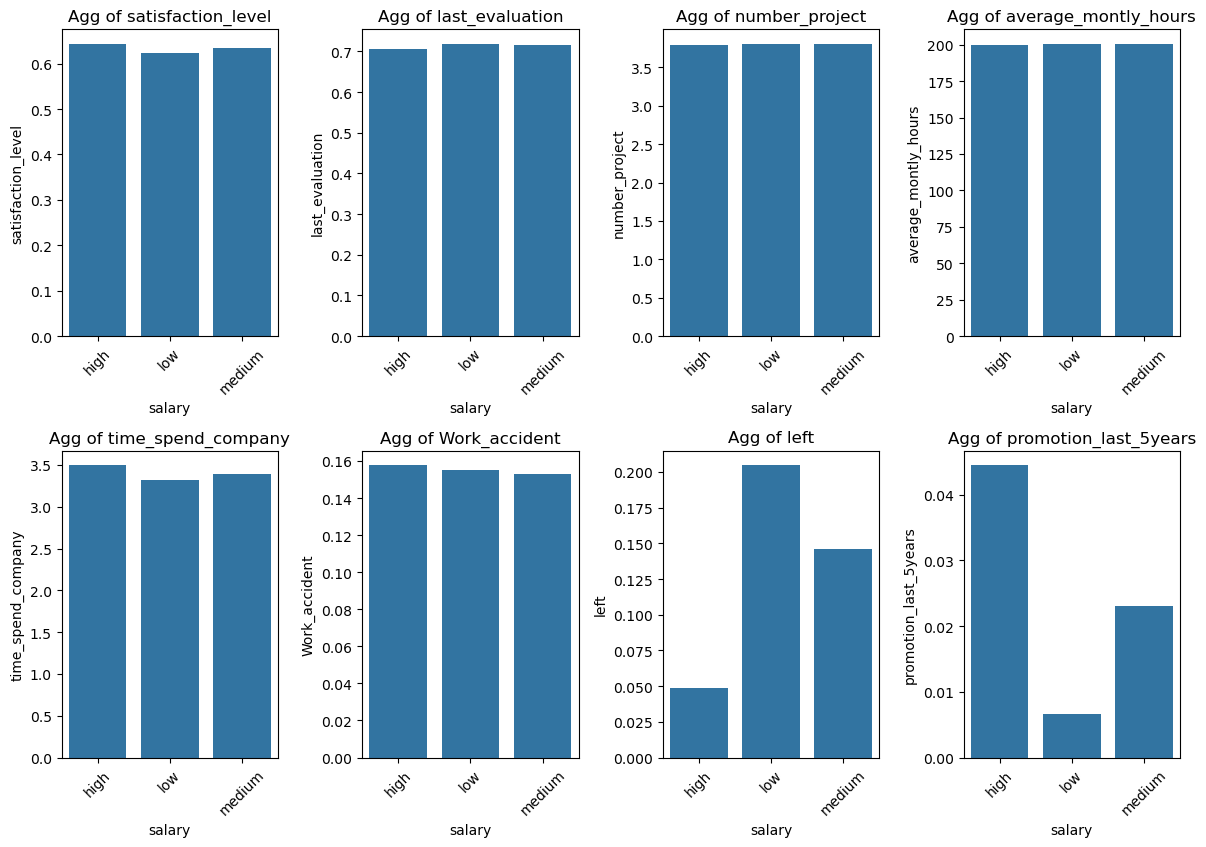

In [23]:
aggregate_dataset(df, numeric_types.columns, "salary", "mean")

# Scatter Plots

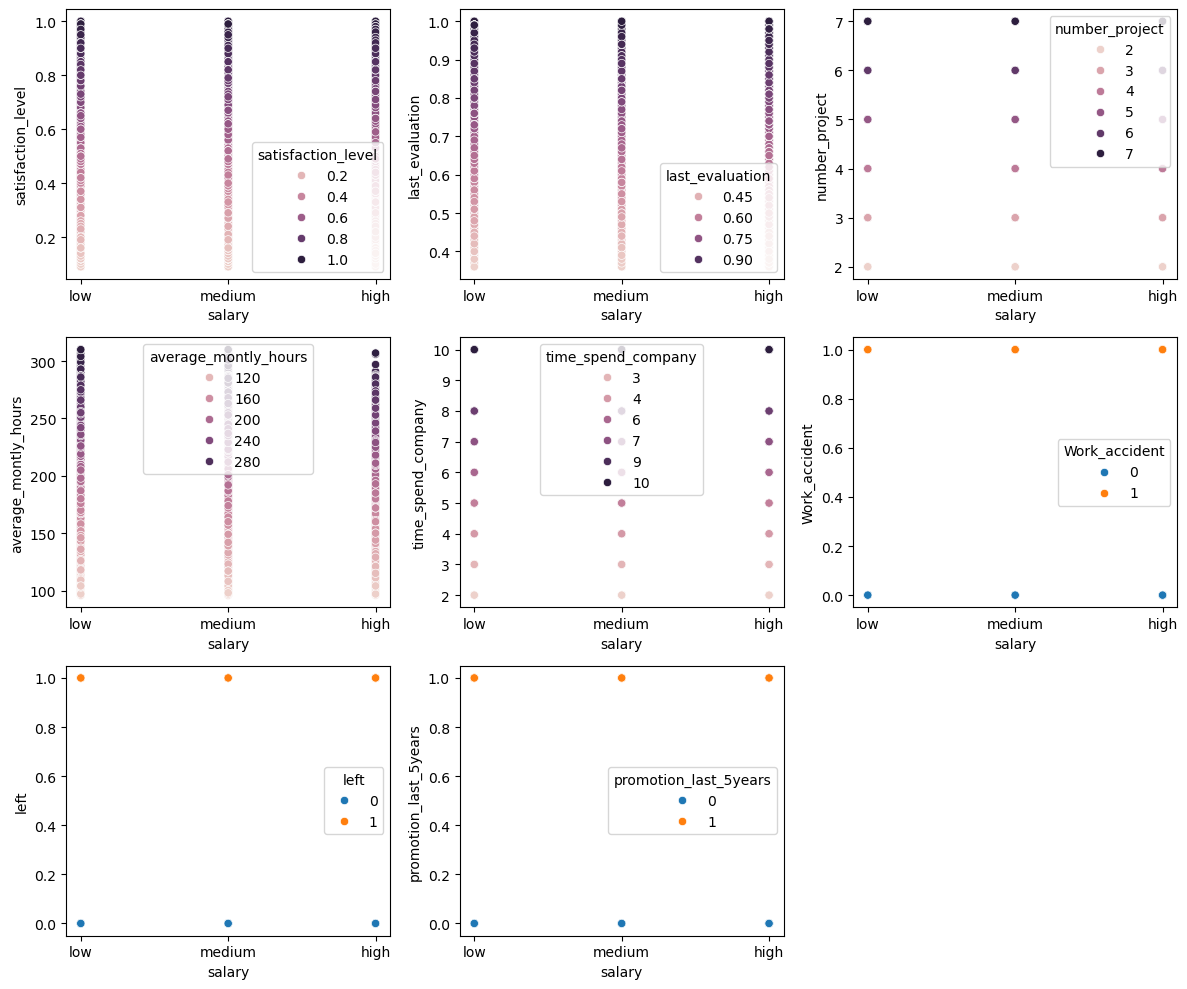

In [25]:
scatter_plot(df, numeric_types.columns, "salary")

# Highest Paid Salaries By Profession

In [27]:
highest_paid = df[df["salary"] == "high"]

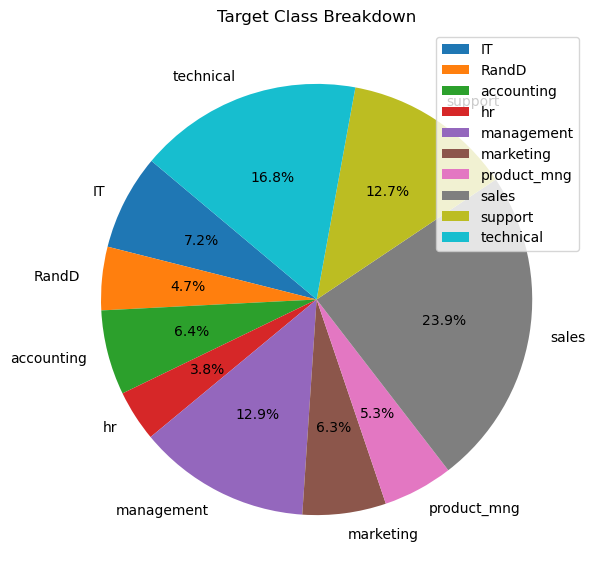

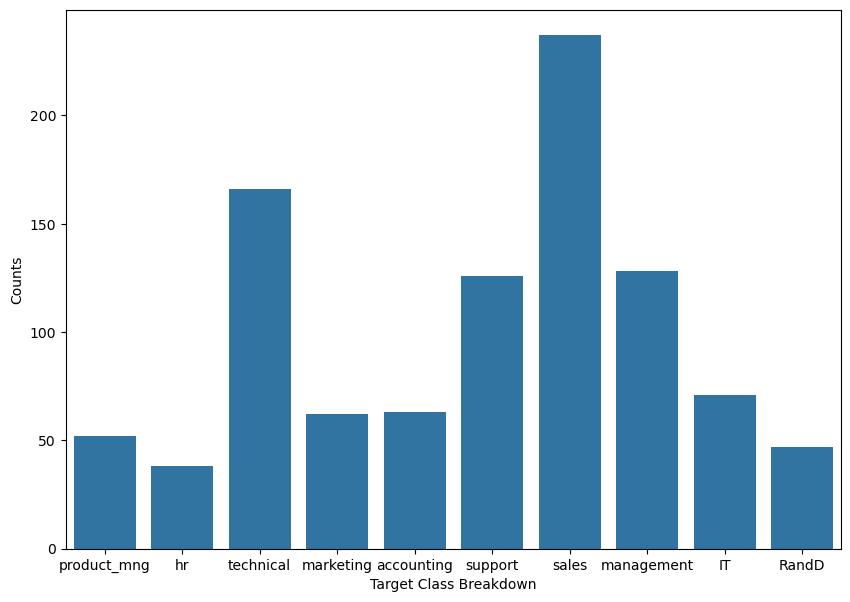

In [30]:
check_class_imbalance(highest_paid["Department"])

# Hightest Paid Earners Who Left The Company

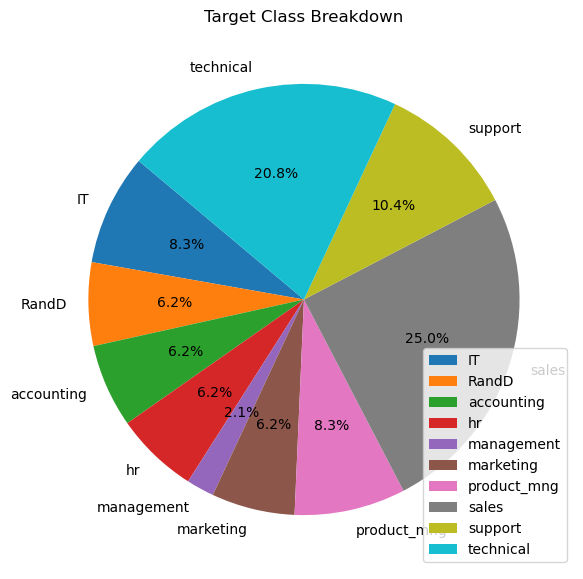

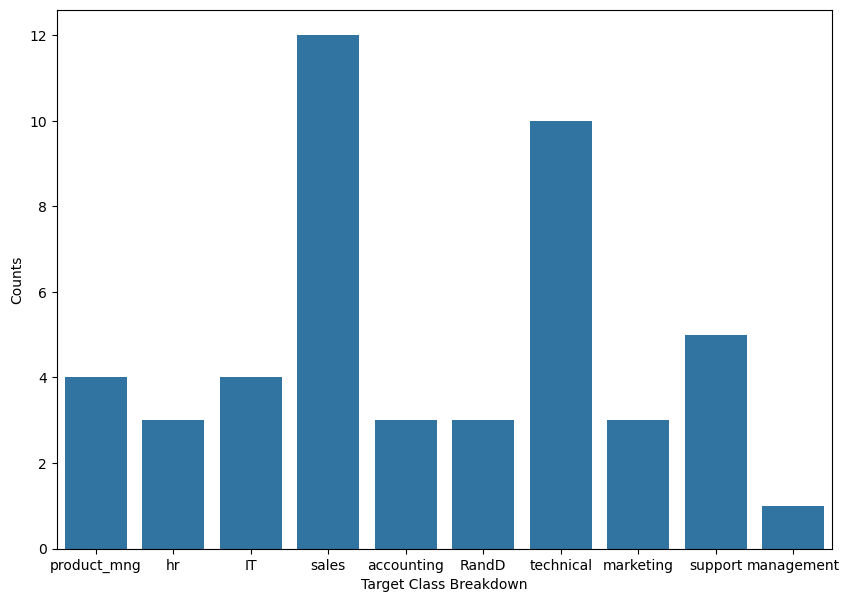

In [67]:
highest_paid_left = highest_paid[highest_paid["left"] ==1]
check_class_imbalance(highest_paid_left["Department"])

# Highest Paid Aggregate Stats

In [31]:
highest_paid.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,0.643343,0.706838,3.791919,200.067677,3.493939,0.157576,0.048485,0.044444
std,0.226611,0.158864,1.063759,47.477252,1.713995,0.364527,0.214897,0.206185
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.510000,0.570000,3.000000,161.250000,2.000000,0.000000,0.000000,0.000000
50%,0.660000,0.710000,4.000000,201.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.840000,5.000000,241.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,307.000000,10.000000,1.000000,1.000000,1.000000


# Medium Paid Earners 

In [68]:
medium_paid = df[df["salary"] == "medium"]
medium_paid.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000,5261.00000,5261.000000
mean,0.634723,0.716539,3.806121,200.587341,3.389850,0.153013,0.14617,0.022999
std,0.237343,0.168320,1.140529,48.371399,1.363666,0.360034,0.35331,0.149916
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.00000,0.000000
25%,0.490000,0.570000,3.000000,157.000000,3.000000,0.000000,0.00000,0.000000
50%,0.660000,0.720000,4.000000,201.000000,3.000000,0.000000,0.00000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.00000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.00000,1.000000


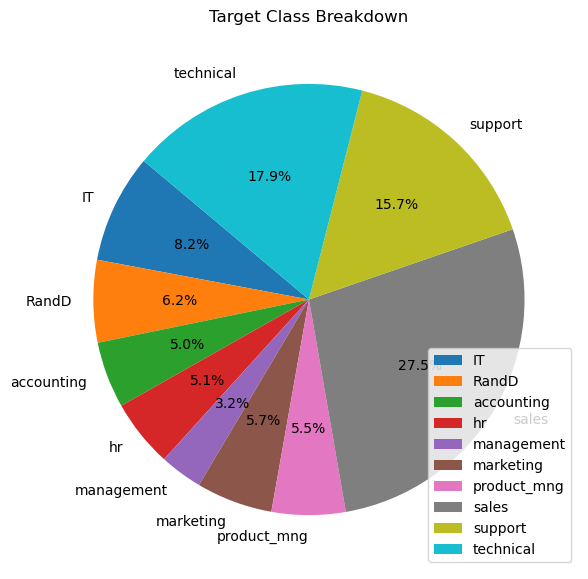

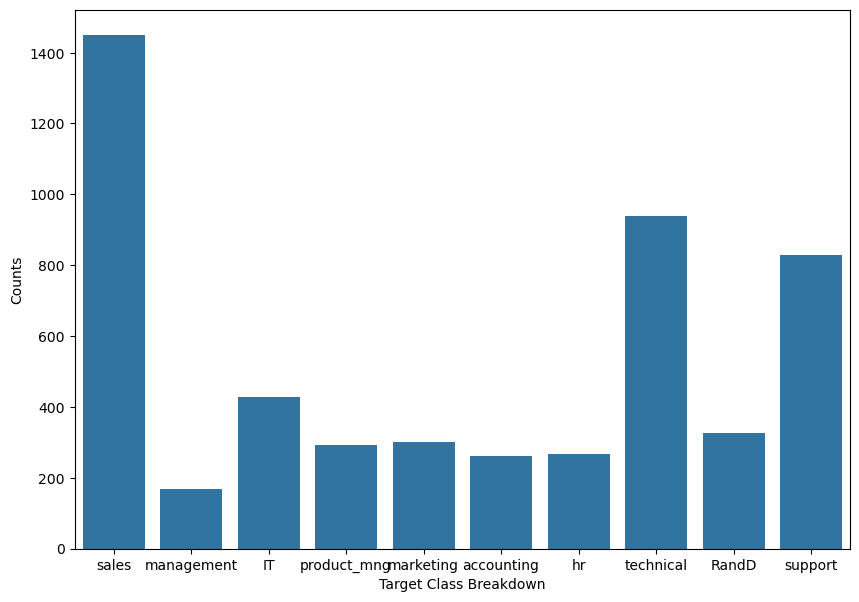

In [69]:
check_class_imbalance(medium_paid["Department"])

# Medium Paid Earners Who Left the Company

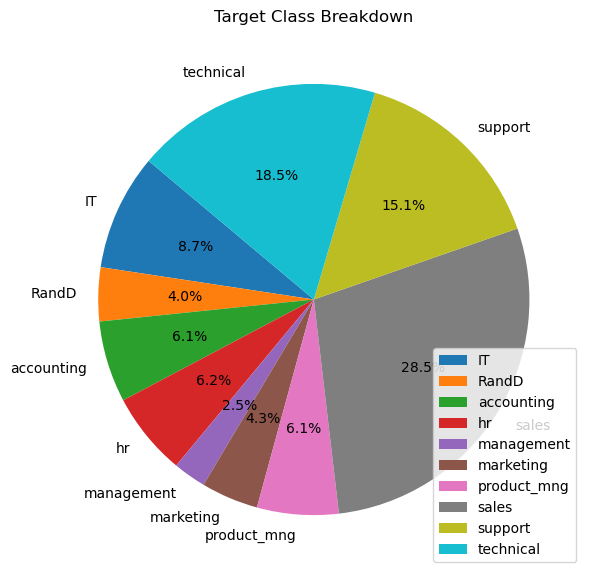

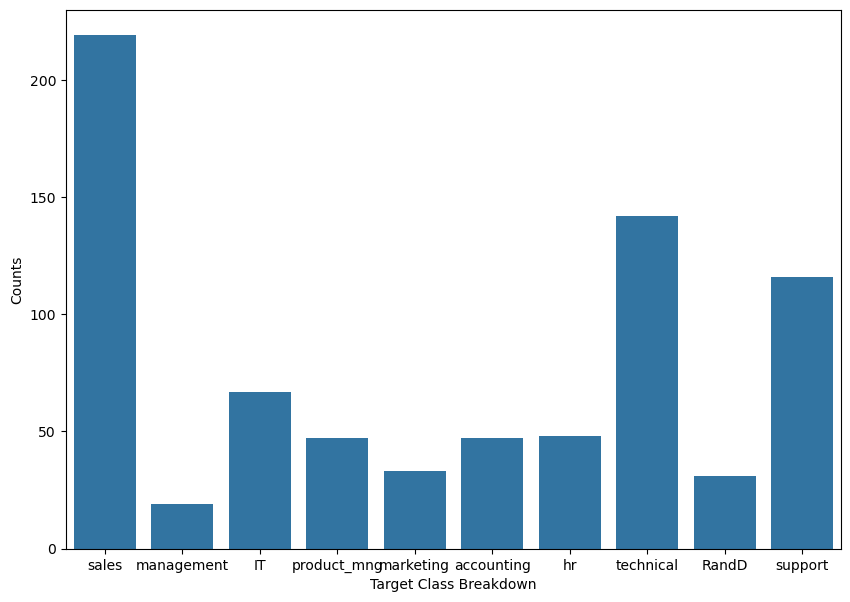

In [76]:
medium_paid_left = medium_paid[medium_paid["left"] == 1]
check_class_imbalance(medium_paid_left["Department"])

# Lowest Paid

In [72]:
lowest_paid = df[df["salary"] == "low"]
lowest_paid.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000,5740.000000
mean,0.622655,0.718512,3.801742,200.439199,3.319686,0.154878,0.204530,0.006620
std,0.246637,0.169913,1.199871,49.271065,1.216886,0.361820,0.403393,0.081102
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.450000,0.570000,3.000000,157.000000,3.000000,0.000000,0.000000,0.000000
50%,0.650000,0.720000,4.000000,199.000000,3.000000,0.000000,0.000000,0.000000
75%,0.830000,0.870000,5.000000,244.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


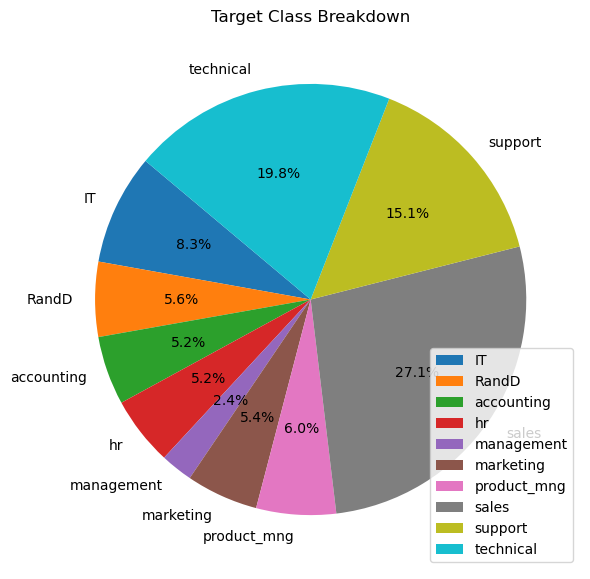

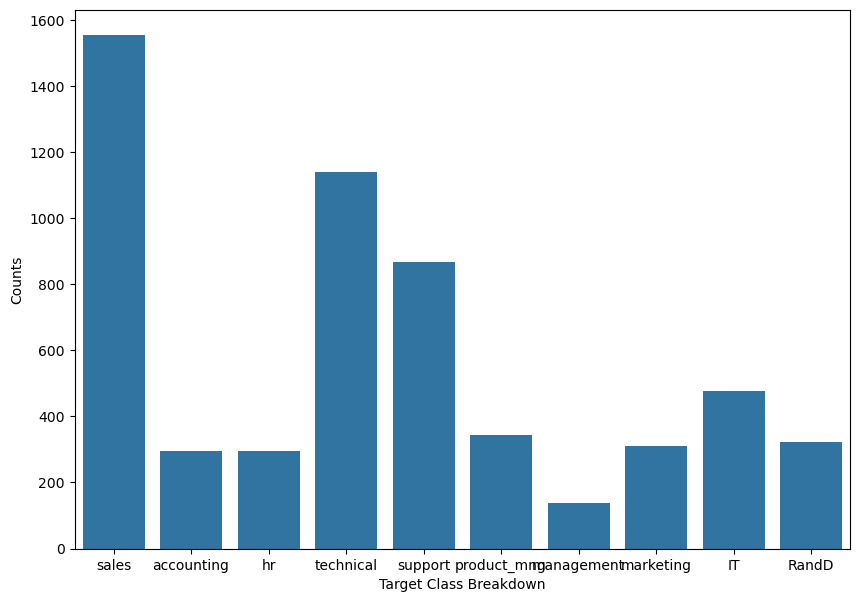

In [74]:
check_class_imbalance(lowest_paid["Department"])

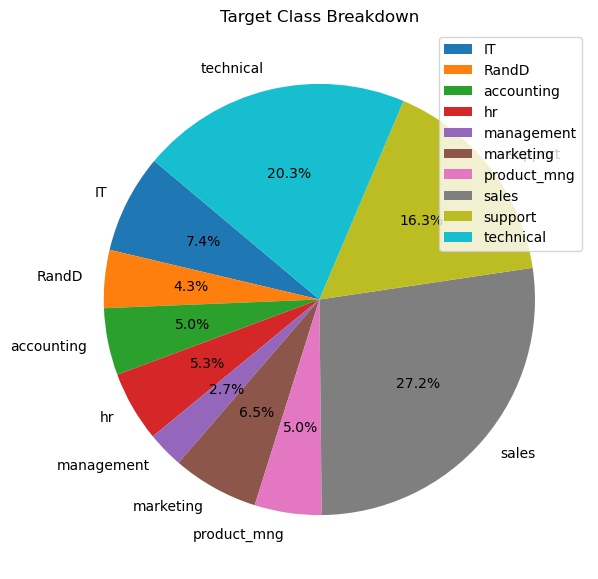

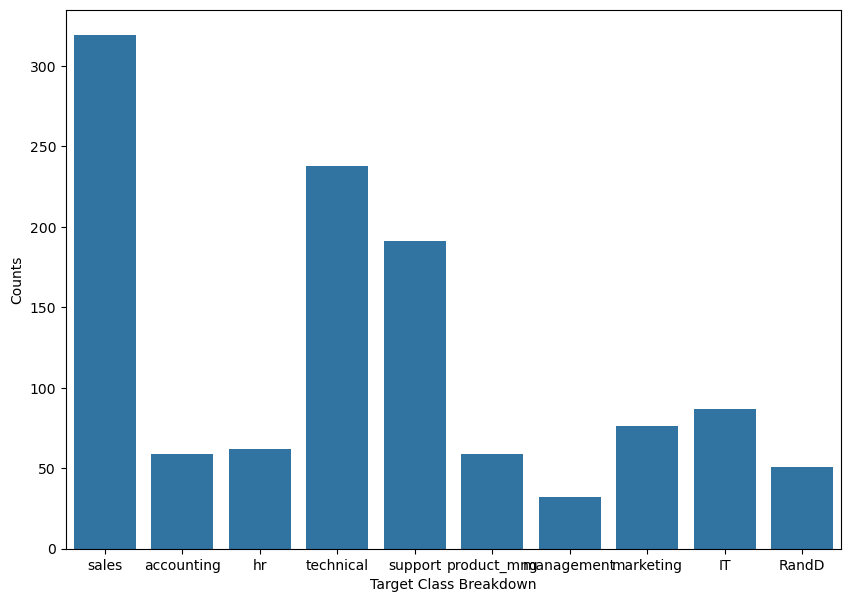

In [75]:
lowest_paid_left = lowest_paid[lowest_paid["left"] ==1]
check_class_imbalance(lowest_paid_left["Department"])

# Average Stats based on salary

In [89]:
high_stats = aggregate_salaries(highest_paid)
medium_stats = aggregate_salaries(medium_paid)
low_stats = aggregate_salaries(lowest_paid)

In [91]:
high_stats

,department,avg_monhtly_hours,total_hours,total_turnover,percentage_left,num_work_accidents,percentage_work_accidents,num_promotions,mean_promotions,mean_years_at_company,sum_years_at_company,mean_projects,sum_projects,mean_statisfaction_level,total_satisfaction_level,mean_evaluation,sum_evaluation
0,product_mng,195.961538,10190,4,7.692308,11,21.153846,0,0.000000,3.519231,183,3.807692,198,0.620769,32.28,0.673269,35.01
1,management,199.460938,25531,1,0.781250,20,15.625000,23,0.179688,4.929688,631,3.781250,484,0.657656,84.18,0.718203,91.93
2,sales,199.772152,47346,12,5.063291,30,12.658228,9,0.037975,3.409283,808,3.843882,911,0.653080,154.78,0.699114,165.69
3,accounting,203.841270,12842,3,4.761905,14,22.222222,5,0.079365,3.126984,197,3.920635,247,0.630317,39.71,0.729048,45.93
4,hr,211.710526,8045,3,7.894737,4,10.526316,2,0.052632,2.842105,108,3.868421,147,0.693947,26.37,0.750789,28.53
5,IT,196.169014,13928,4,5.633803,4,5.633803,0,0.000000,3.084507,219,3.887324,276,0.641127,45.52,0.713521,50.66
6,RandD,201.702128,9480,3,6.382979,8,17.021277,1,0.021277,3.361702,158,3.744681,176,0.600000,28.20,0.703617,33.07
7,marketing,189.951613,11777,3,4.838710,9,14.516129,3,0.048387,3.435484,213,3.580645,222,0.624355,38.71,0.680968,42.22
8,technical,200.524096,33287,10,6.024096,26,15.662651,1,0.006024,3.246988,539,3.680723,611,0.633916,105.23,0.704217,116.90
9,support,203.500000,25641,5,3.968254,30,23.809524,0,0.000000,3.198413,403,3.825397,482,0.650238,81.93,0.712937,89.83


In [92]:
medium_stats

,department,avg_monhtly_hours,total_hours,total_turnover,percentage_left,num_work_accidents,percentage_work_accidents,num_promotions,mean_promotions,mean_years_at_company,sum_years_at_company,mean_projects,sum_projects,mean_statisfaction_level,total_satisfaction_level,mean_evaluation,sum_evaluation
0,sales,201.148378,291464,219,15.113872,240,16.563147,40,0.027605,3.441684,4987,3.780538,5478,0.632195,916.05,0.712988,1033.12
1,management,201.532544,34059,19,11.242604,29,17.159763,10,0.059172,3.840237,649,3.905325,660,0.606036,102.42,0.737160,124.58
2,IT,202.564103,86900,67,15.617716,59,13.752914,1,0.002331,3.428904,1471,3.804196,1632,0.631422,270.88,0.714545,306.54
3,product_mng,196.539519,57193,47,16.151203,42,14.432990,0,0.000000,3.333333,970,3.773196,1098,0.631787,183.85,0.705636,205.34
4,marketing,197.880399,59562,33,10.963455,52,17.275748,18,0.059801,3.451827,1039,3.687708,1110,0.650233,195.72,0.715017,215.22
5,accounting,199.698473,52321,47,17.938931,35,13.358779,4,0.015267,3.500000,917,3.820611,1001,0.610000,159.82,0.719962,188.63
6,hr,195.606742,52227,48,17.977528,33,12.359551,7,0.026217,3.382022,903,3.610487,964,0.616404,164.58,0.704682,188.15
7,technical,200.071277,188067,142,15.106383,140,14.893617,14,0.014894,3.332979,3133,3.865957,3634,0.642223,603.69,0.719830,676.64
8,RandD,203.224615,66048,31,9.538462,49,15.076923,17,0.052308,3.298462,1072,3.904615,1269,0.637508,207.19,0.707446,229.92
9,support,202.233092,167449,116,14.009662,126,15.217391,10,0.012077,3.252415,2693,3.838164,3178,0.646232,535.08,0.726534,601.57


In [93]:
low_stats

,department,avg_monhtly_hours,total_hours,total_turnover,percentage_left,num_work_accidents,percentage_work_accidents,num_promotions,mean_promotions,mean_years_at_company,sum_years_at_company,mean_projects,sum_projects,mean_statisfaction_level,total_satisfaction_level,mean_evaluation,sum_evaluation
0,sales,199.468126,309774,319,20.540889,228,14.681262,9,0.005795,3.319382,5155,3.763683,5845,0.627244,974.11,0.709704,1102.17
1,accounting,201.290541,59582,59,19.932432,38,12.837838,1,0.003378,3.378378,1000,3.827703,1133,0.601351,178.00,0.722095,213.74
2,hr,201.182432,59550,62,20.945946,43,14.527027,2,0.006757,3.195946,946,3.709459,1098,0.617703,182.84,0.721115,213.45
3,technical,202.064148,229949,238,20.913884,173,15.202109,7,0.006151,3.298770,3754,3.879613,4415,0.615264,700.17,0.722030,821.67
4,support,198.675894,172252,191,22.029988,143,16.493656,6,0.006920,3.344867,2900,3.803922,3298,0.621684,539.00,0.721084,625.18
5,product_mng,201.335277,69058,59,17.201166,56,16.326531,0,0.000000,3.320700,1139,3.810496,1307,0.629534,215.93,0.726851,249.31
6,management,203.431655,28277,32,23.021583,23,16.546763,3,0.021583,3.280576,456,3.805755,529,0.639928,88.95,0.720576,100.16
7,marketing,202.954839,62916,76,24.516129,47,15.161290,6,0.019355,3.390323,1051,3.780645,1172,0.621839,192.77,0.729258,226.07
8,IT,199.569328,94995,87,18.277311,76,15.966387,1,0.002101,3.319328,1580,3.777311,1798,0.635294,302.40,0.715735,340.69
9,RandD,199.279503,64168,51,15.838509,62,19.254658,3,0.009317,3.335404,1074,3.810559,1227,0.620714,199.87,0.719938,231.82


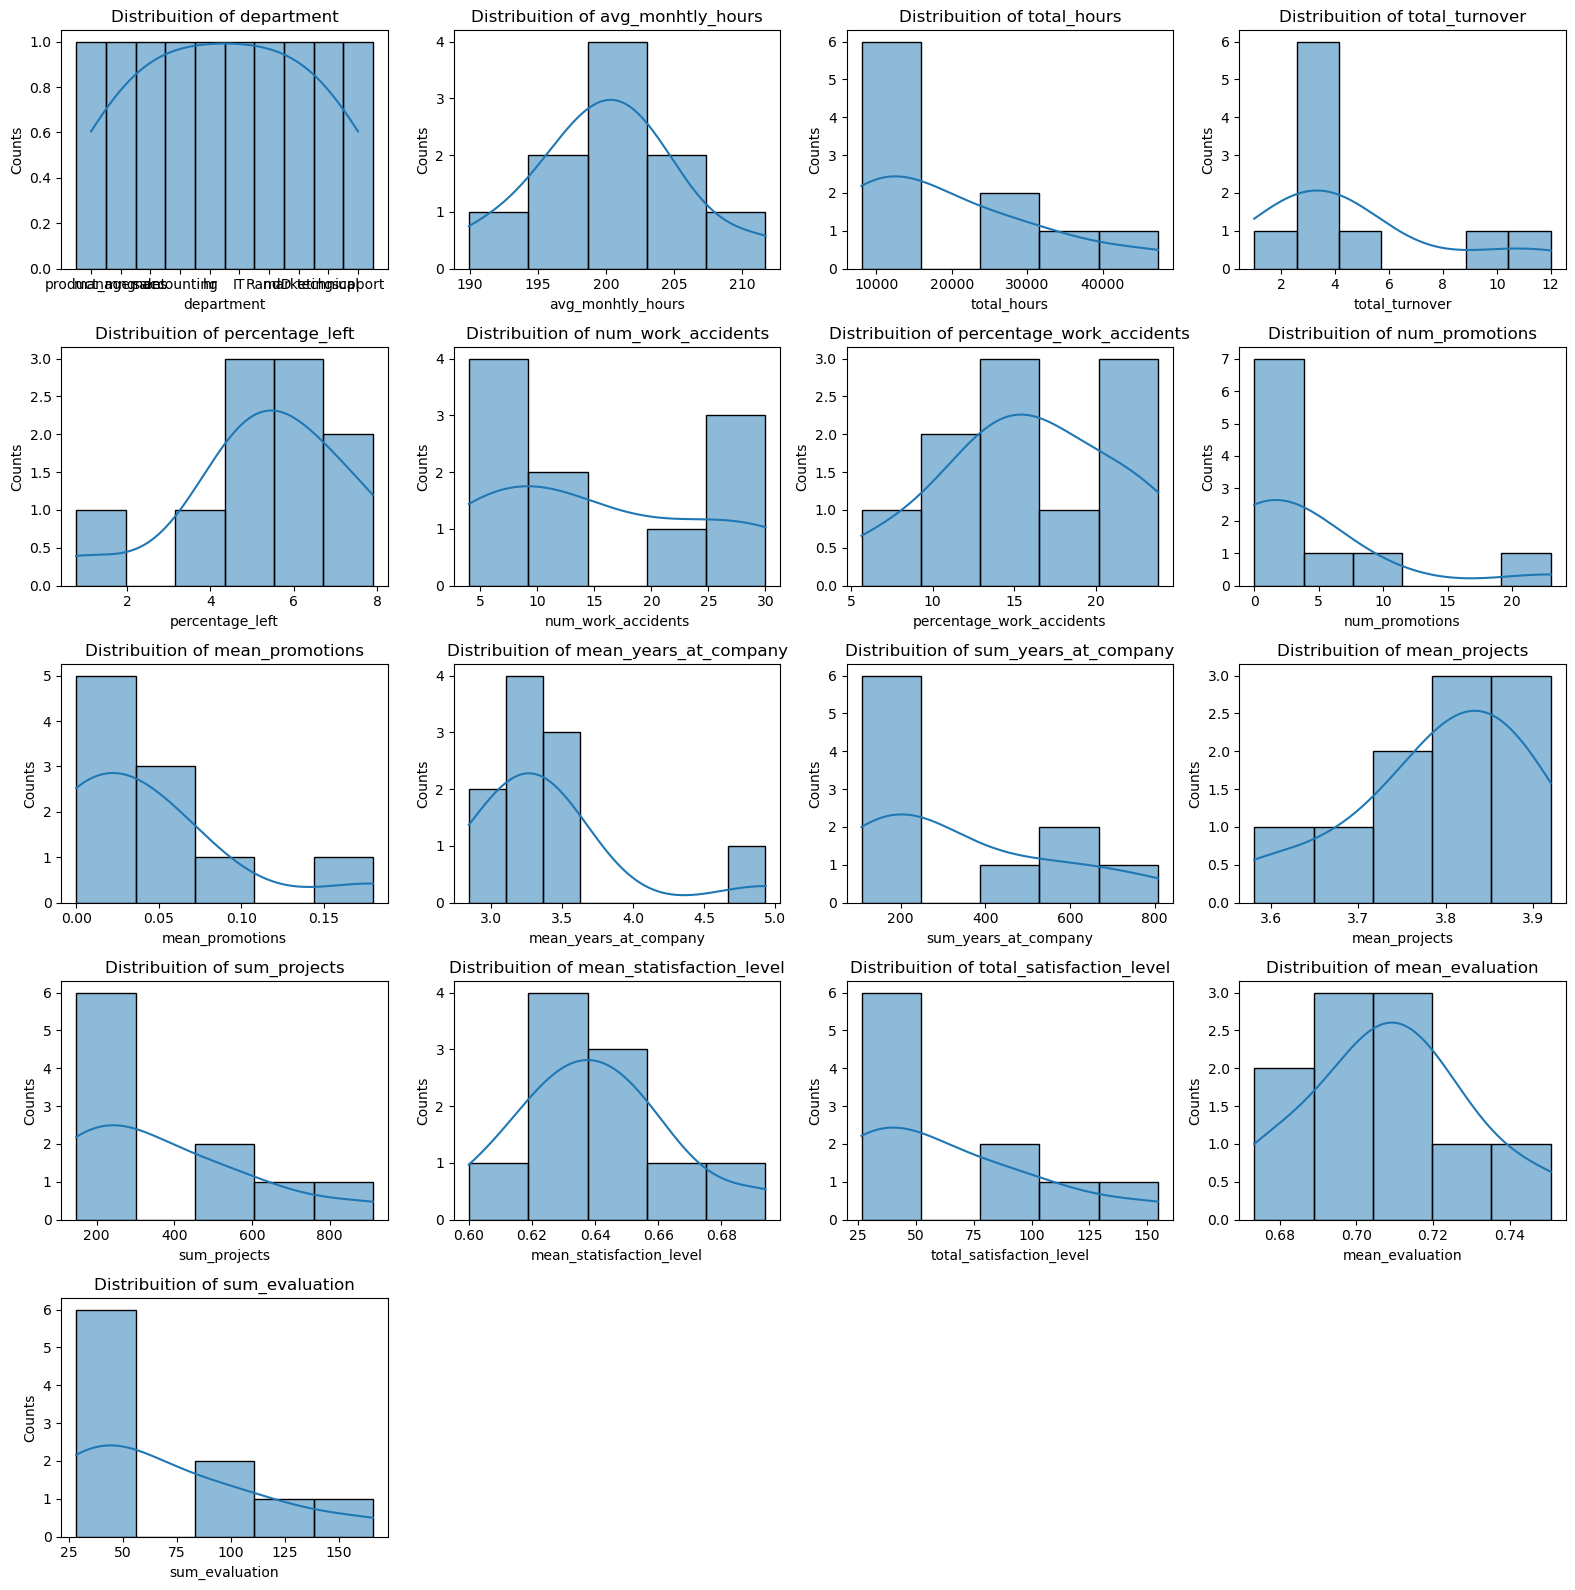

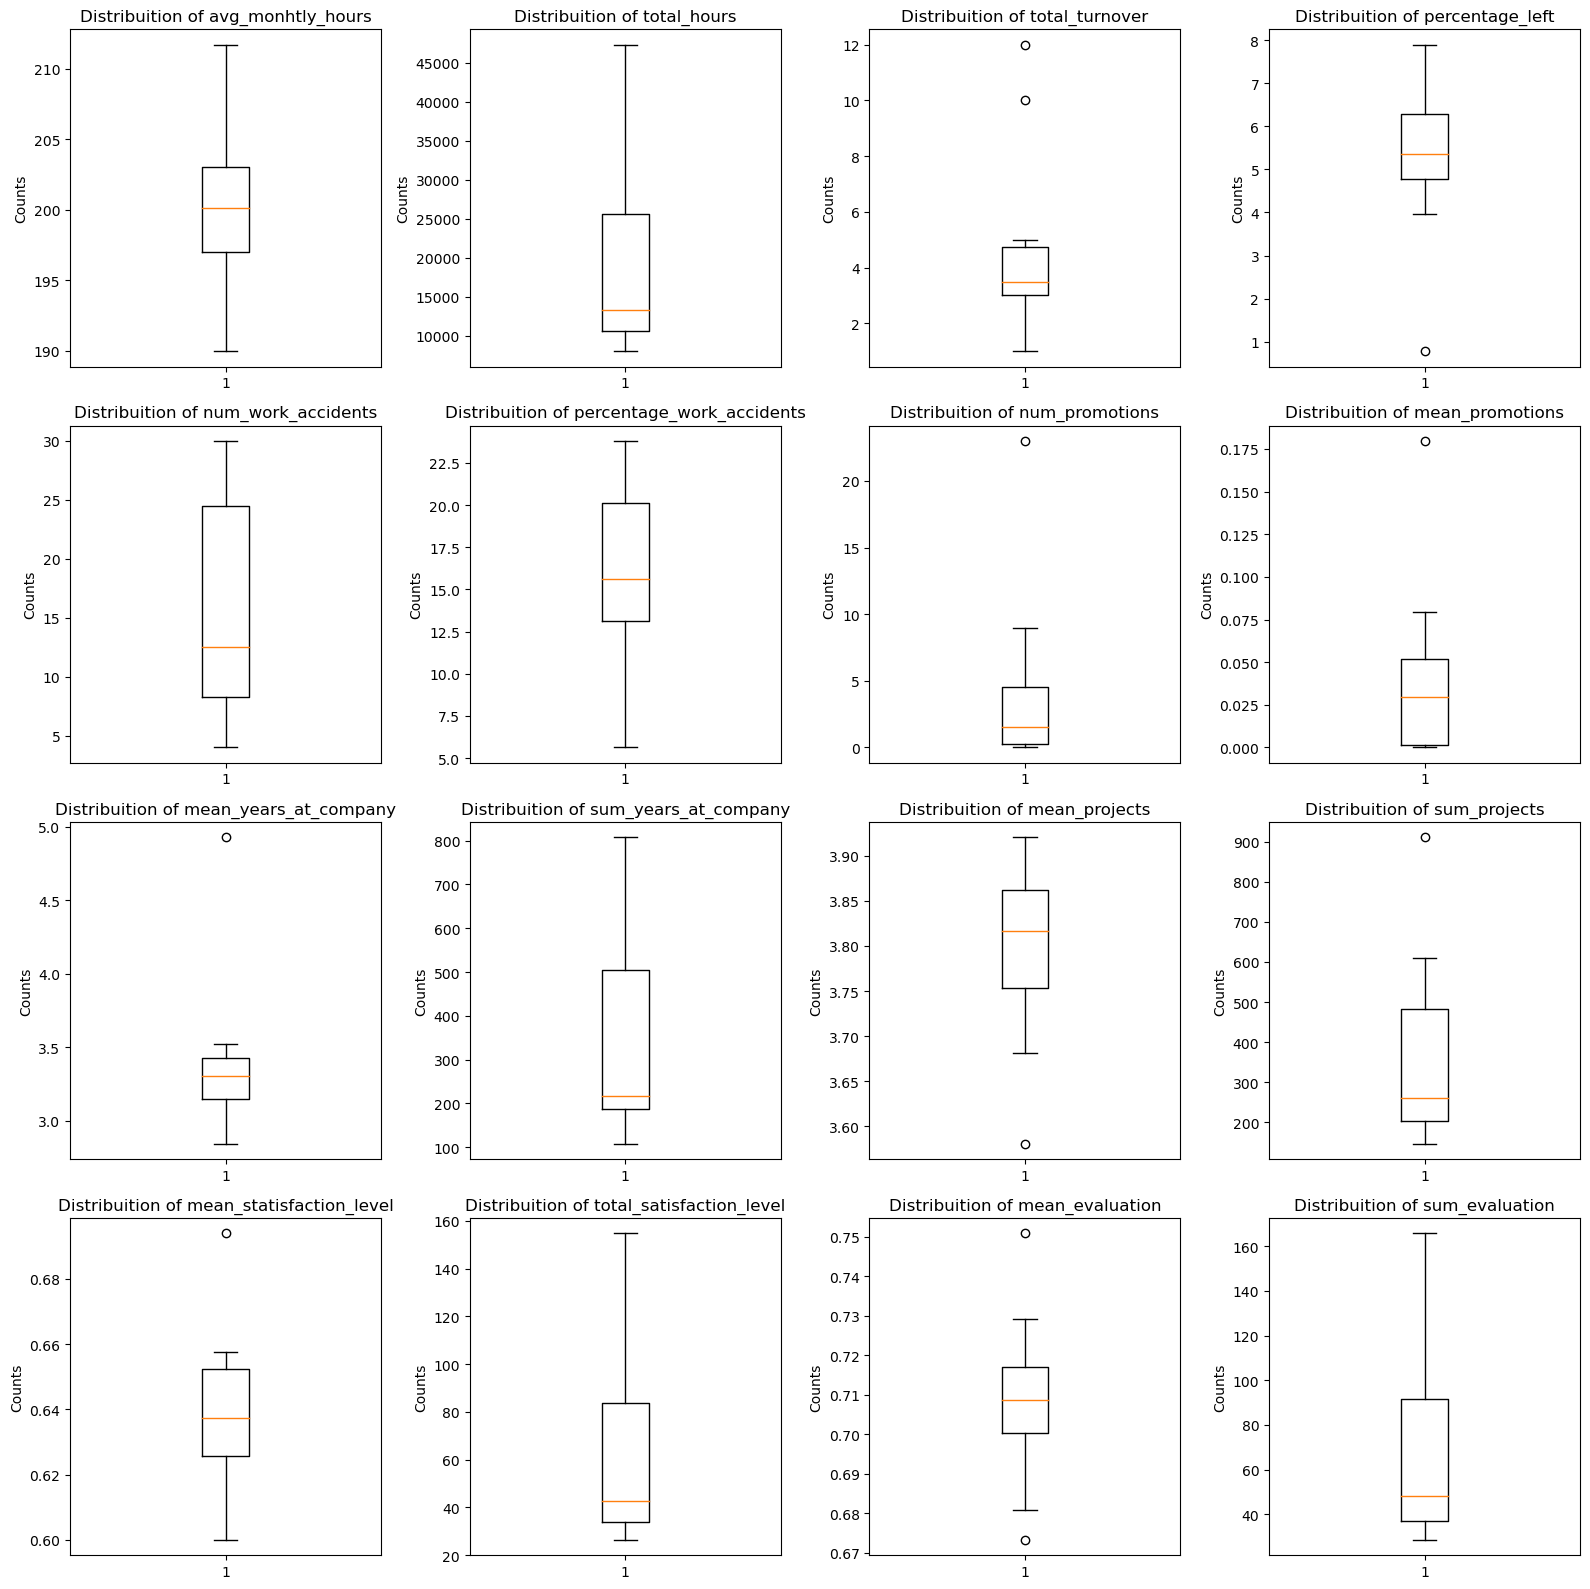

In [97]:
plot_distribution(high_stats, "hist")
plot_distribution(high_stats.drop("department", axis=1), "box")

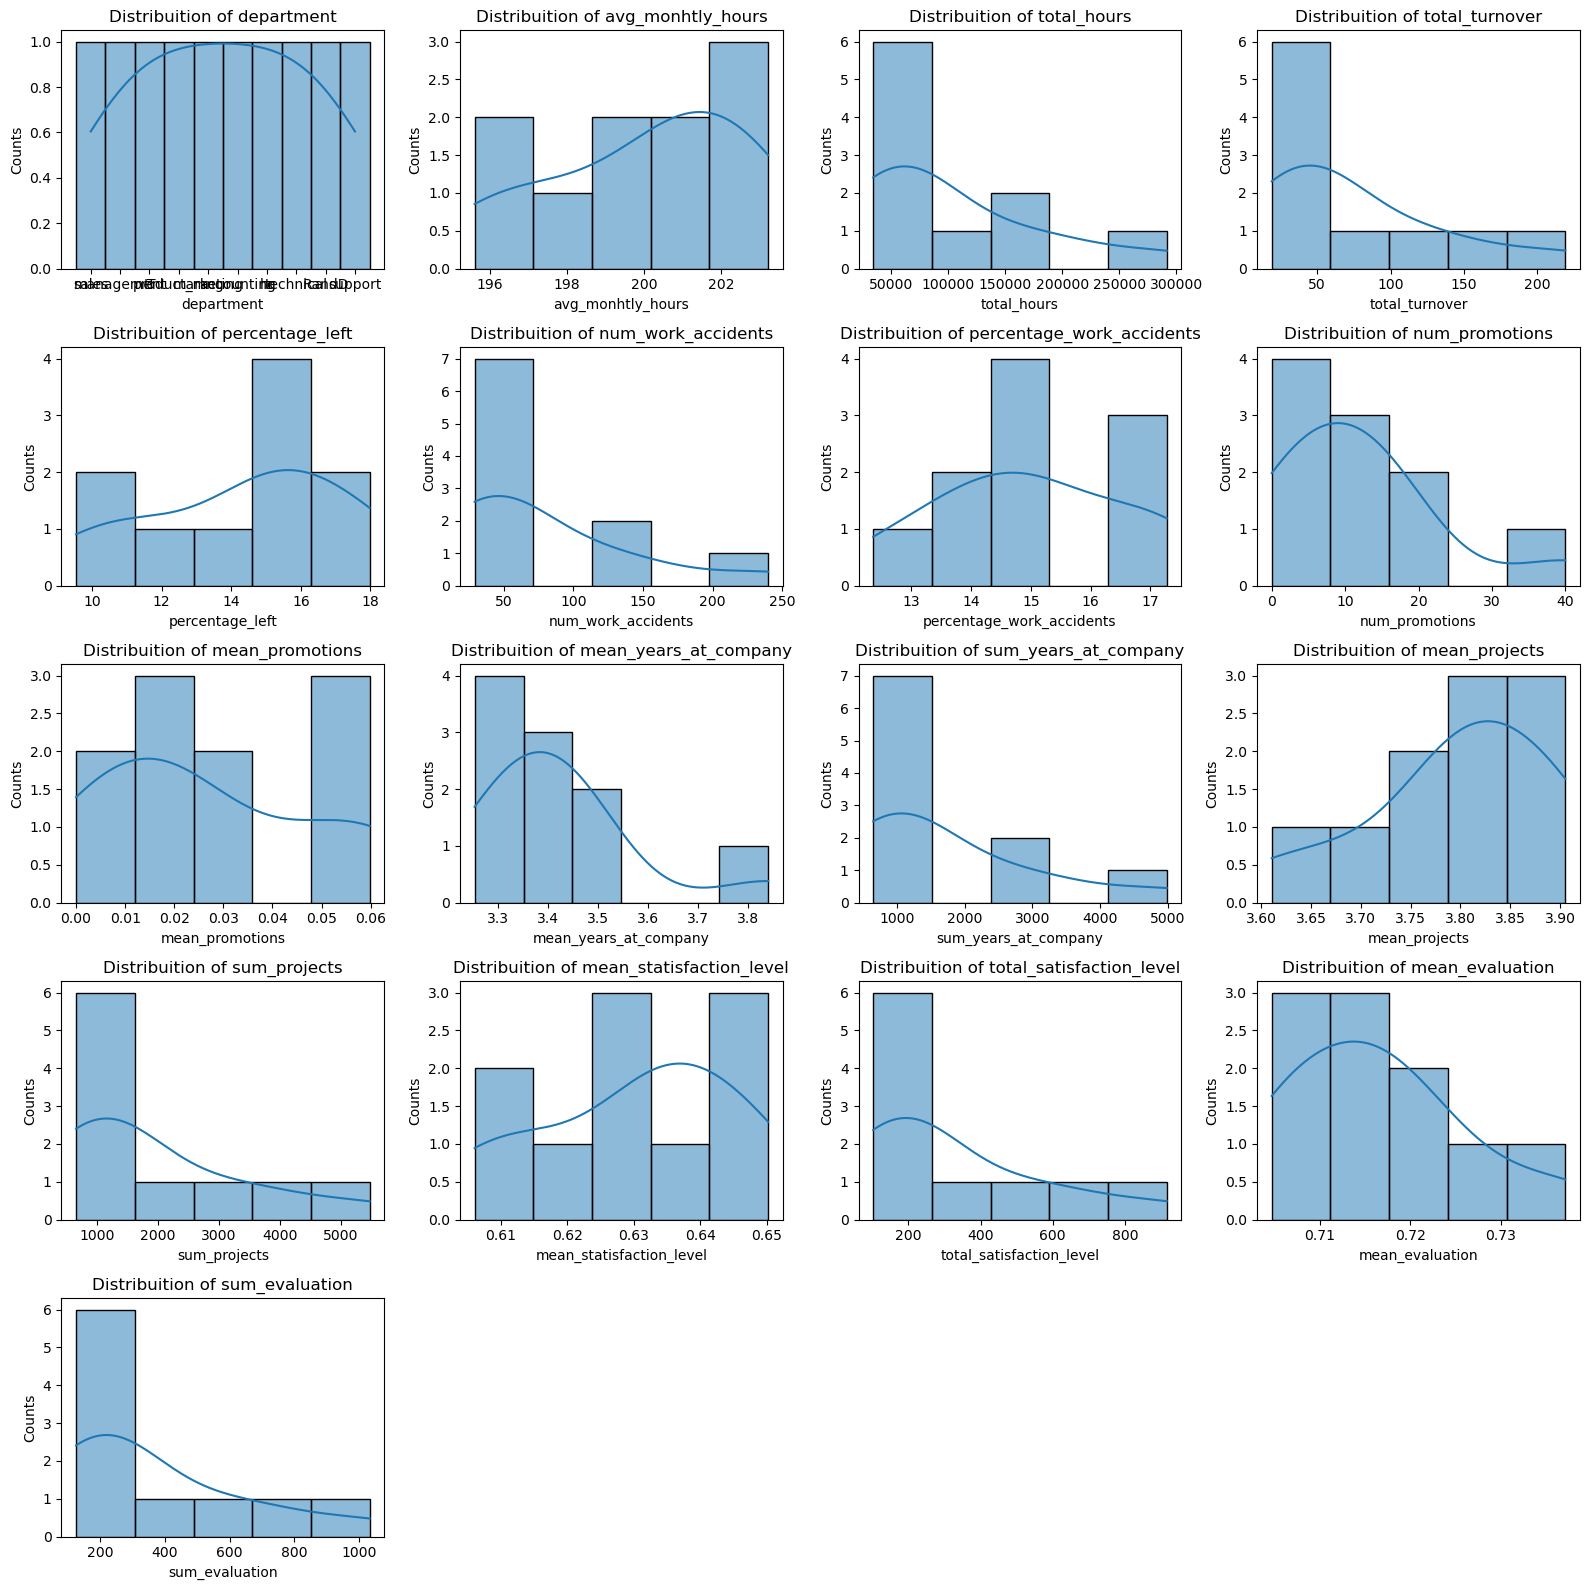

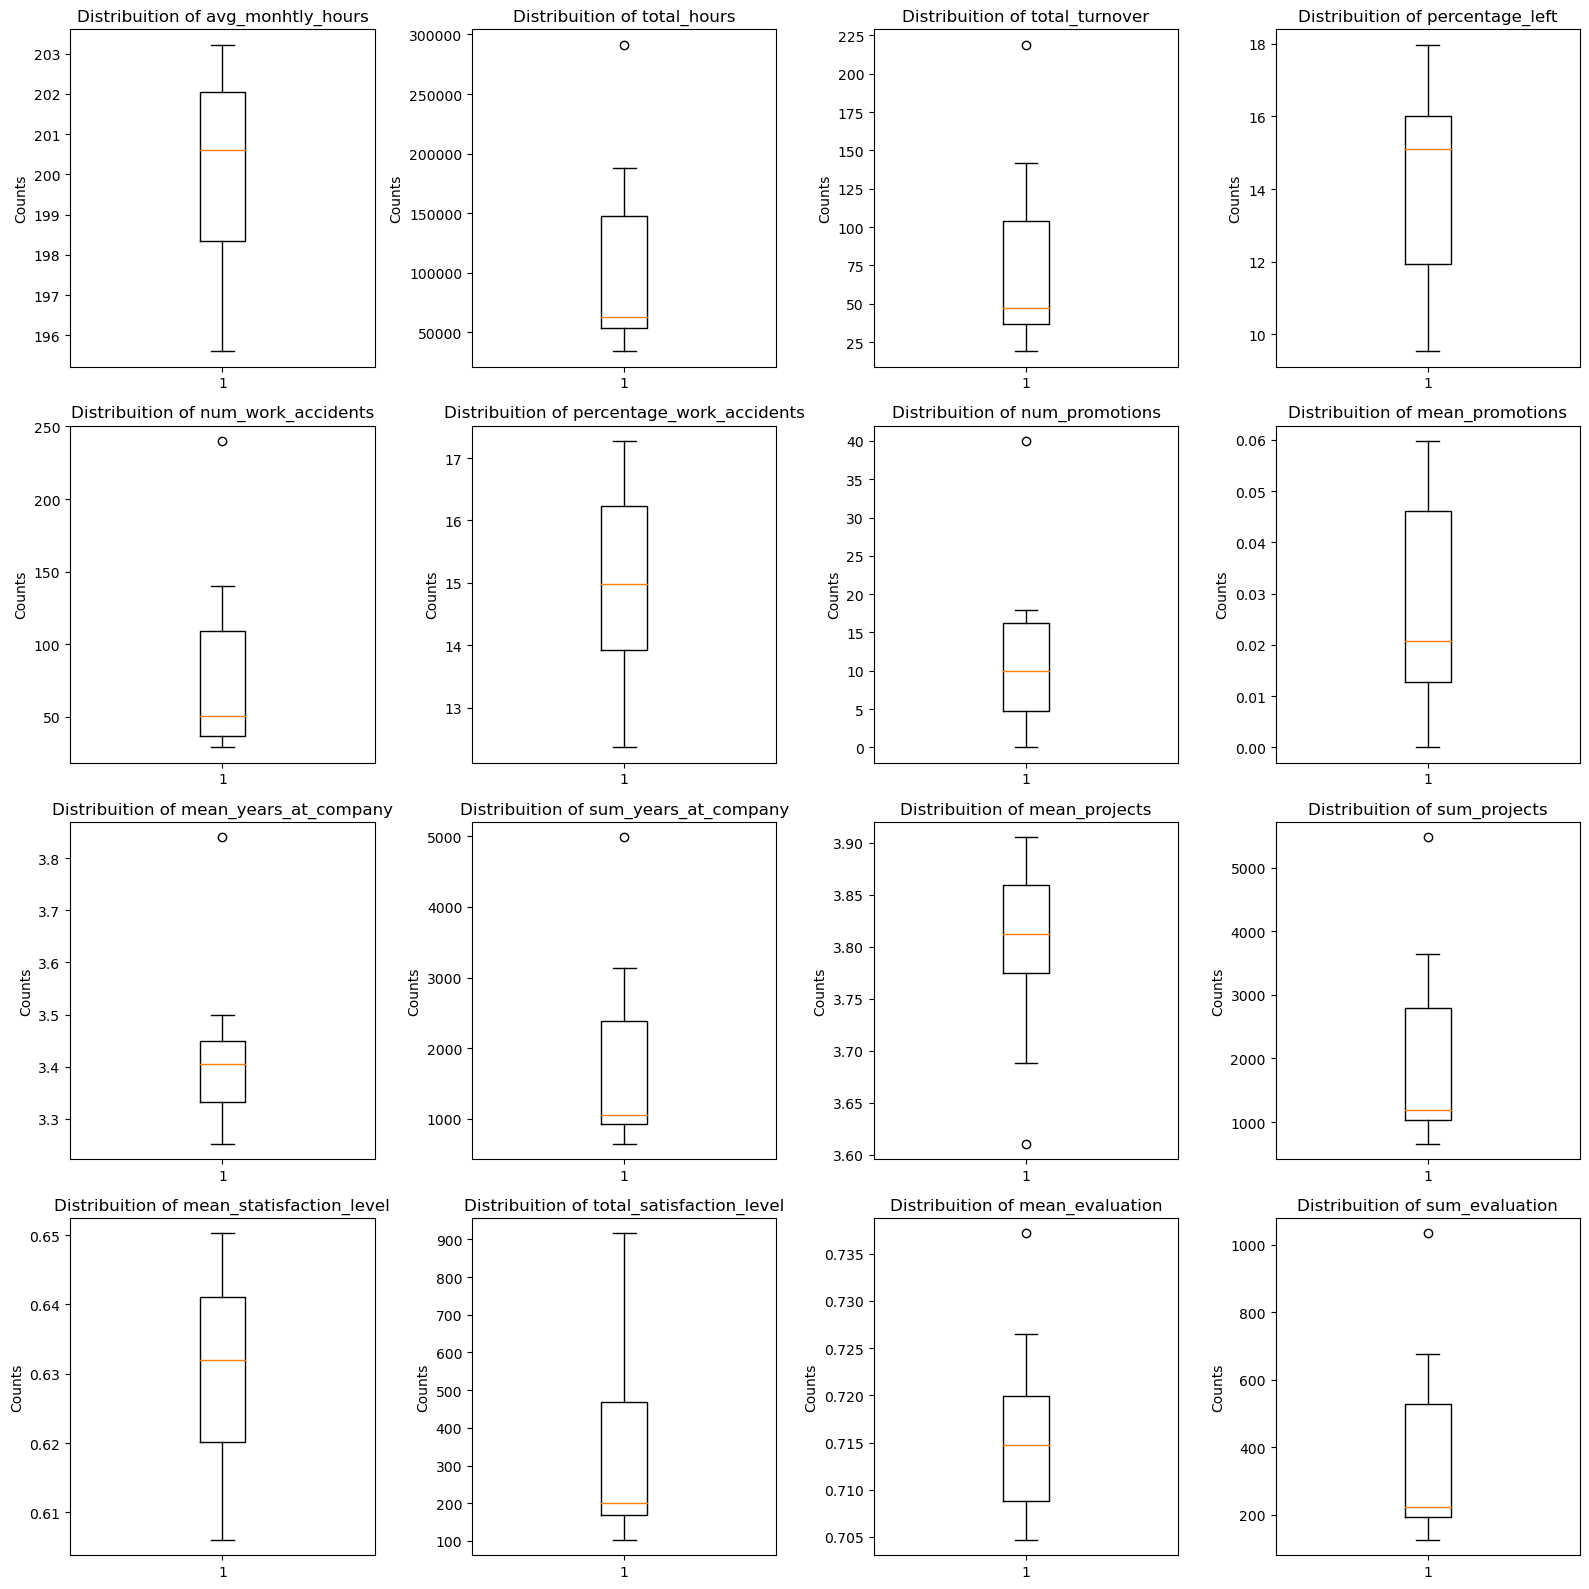

In [99]:
plot_distribution(medium_stats, "hist")
plot_distribution(medium_stats.drop("department", axis=1), "box")

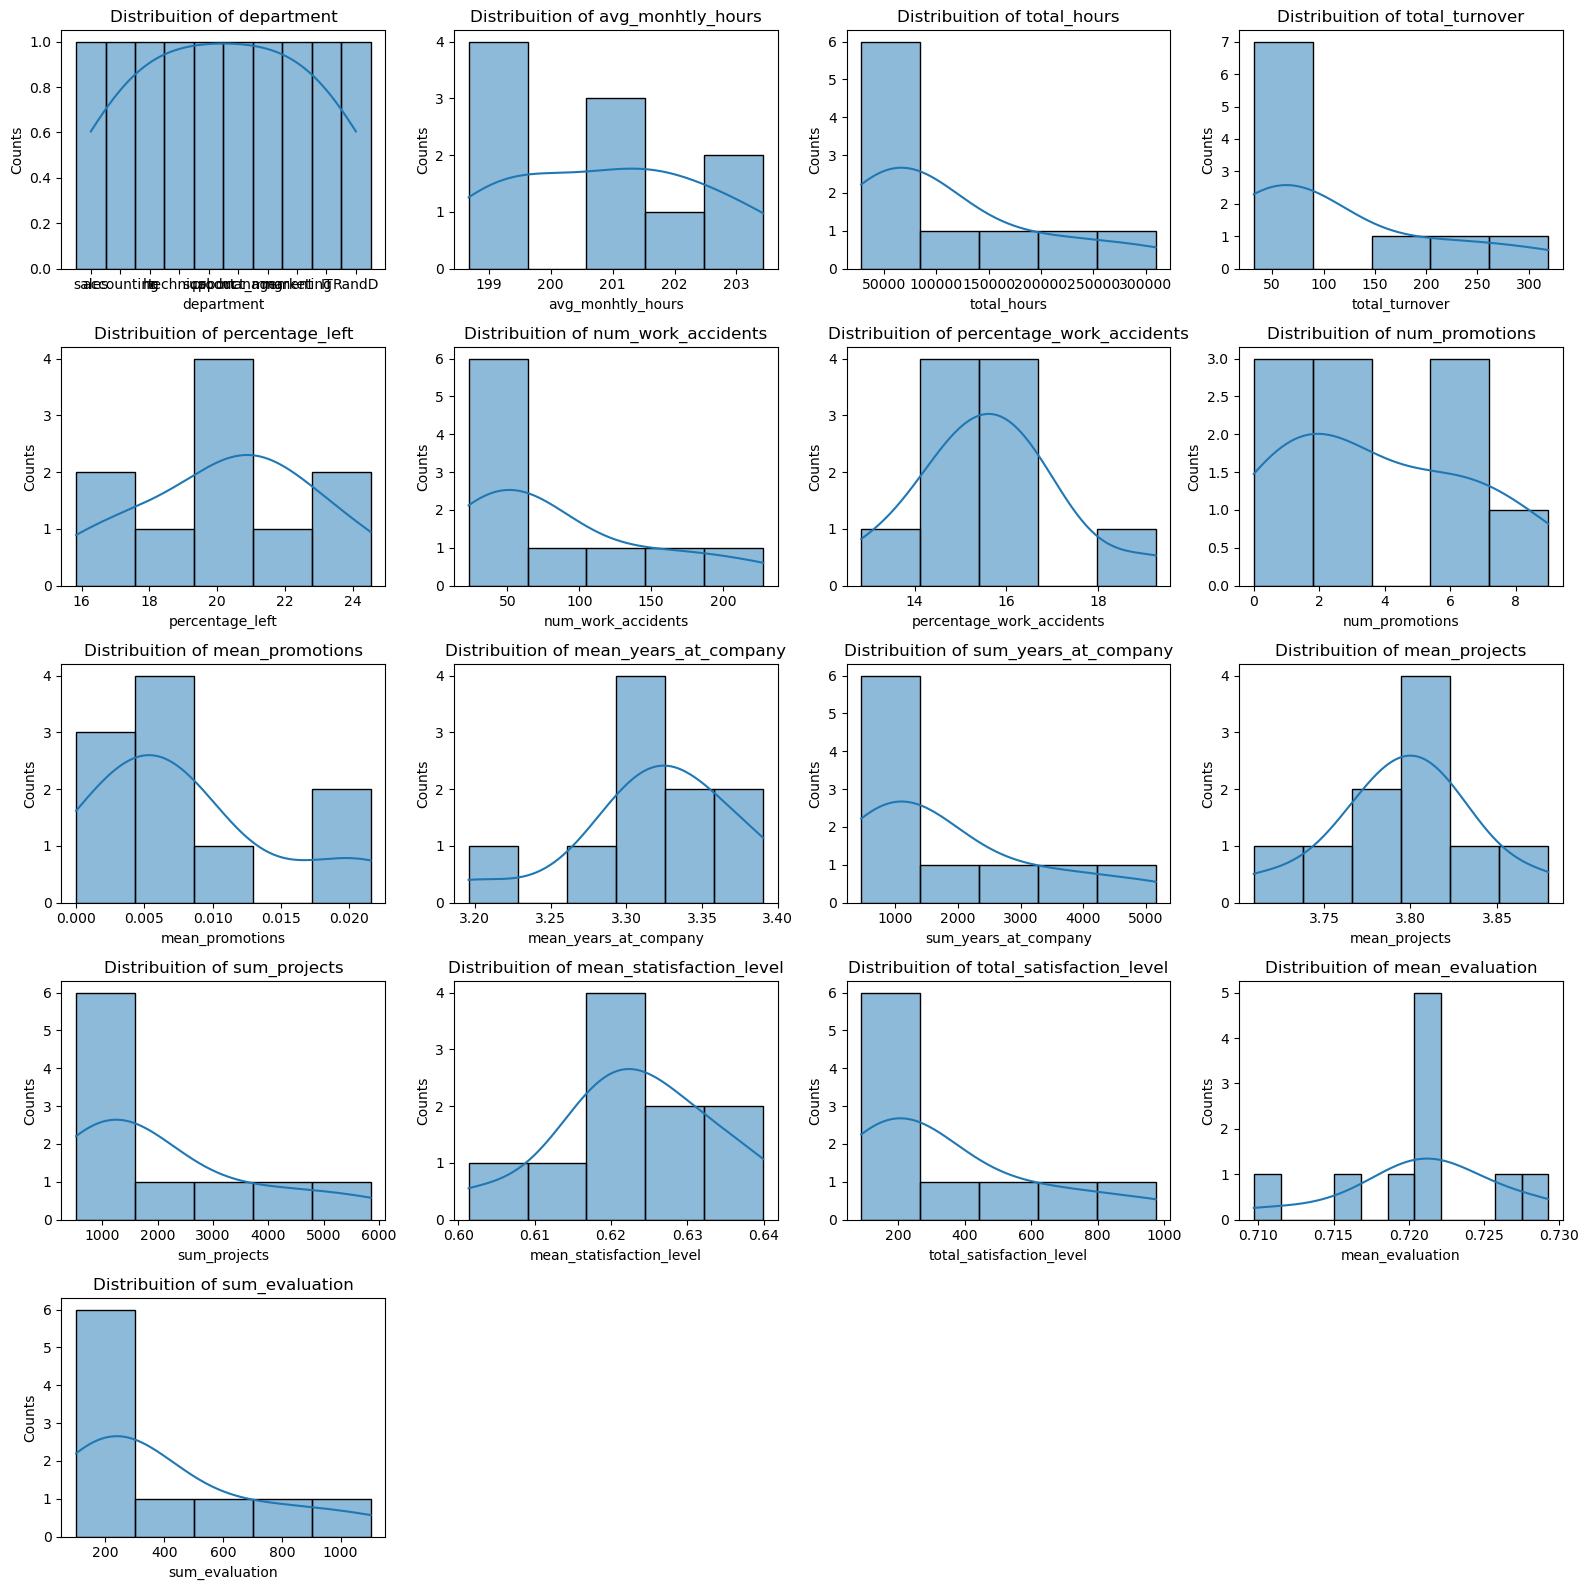

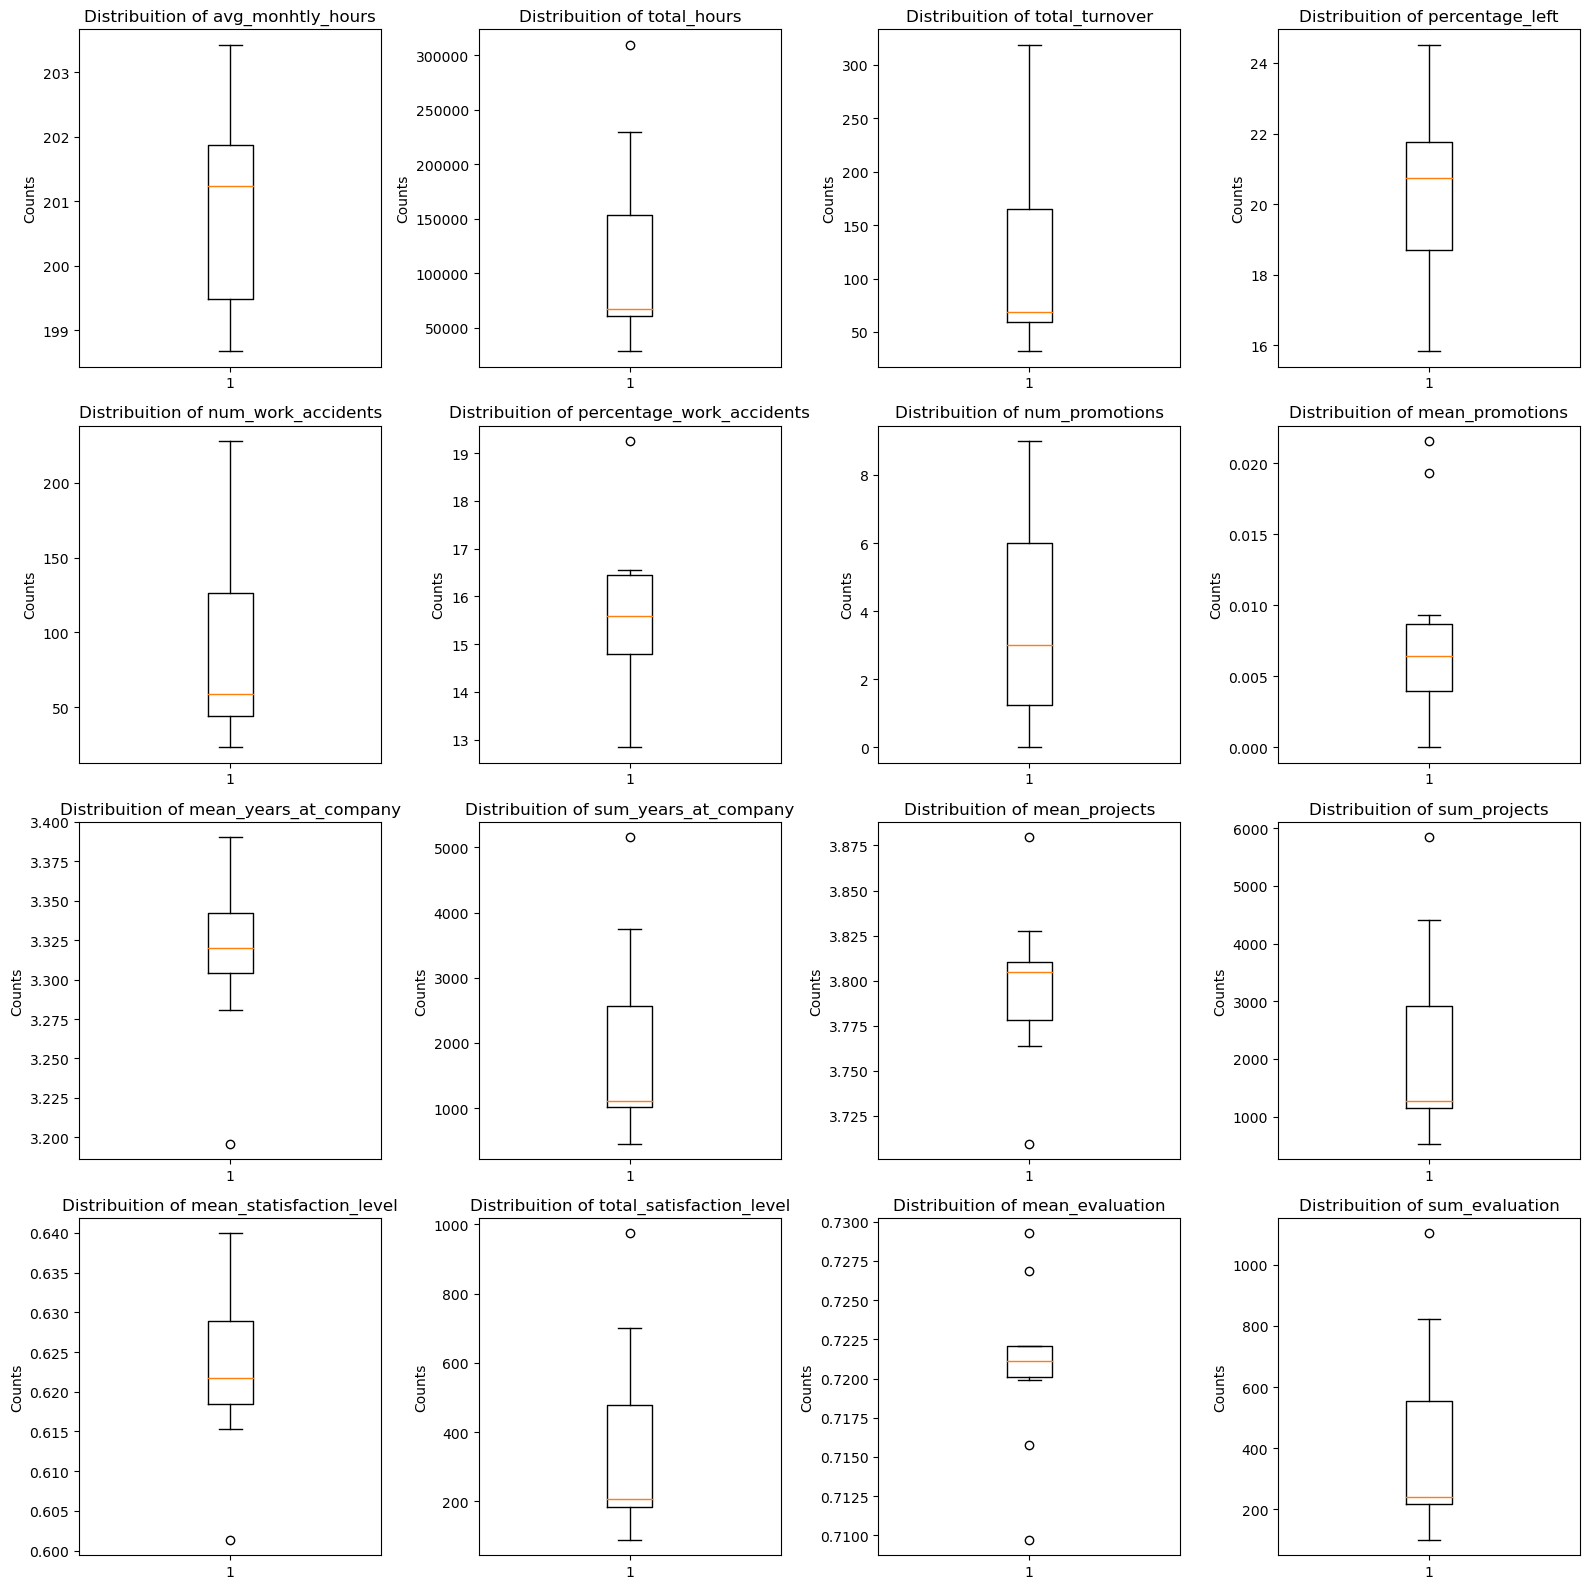

In [100]:
plot_distribution(low_stats, "hist")
plot_distribution(low_stats.drop("department", axis=1), "box")

# 

# Insert Aggregate Stats

In [102]:
df = insert_columns(df, high_stats, "high")
df = insert_columns(df, medium_stats, "medium")
df = insert_columns(df, low_stats, "low")

df.head(25)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary,percentage_left,percentage_work_accidents,mean_promotions,mean_years_at_company,mean_projects,mean_statisfaction_level
0,0.38,0.53,2,157,3,0,1,0,sales,low,20.540889,14.681262,0.005795,3.319382,3.763683,0.627244
1,0.80,0.86,5,262,6,0,1,0,sales,medium,15.113872,16.563147,0.027605,3.441684,3.780538,0.632195
2,0.11,0.88,7,272,4,0,1,0,sales,medium,15.113872,16.563147,0.027605,3.441684,3.780538,0.632195
3,0.72,0.87,5,223,5,0,1,0,sales,low,20.540889,14.681262,0.005795,3.319382,3.763683,0.627244
4,0.37,0.52,2,159,3,0,1,0,sales,low,20.540889,14.681262,0.005795,3.319382,3.763683,0.627244
5,0.41,0.50,2,153,3,0,1,0,sales,low,20.540889,14.681262,0.005795,3.319382,3.763683,0.627244
6,0.10,0.77,6,247,4,0,1,0,sales,low,20.540889,14.681262,0.005795,3.319382,3.763683,0.627244
7,0.92,0.85,5,259,5,0,1,0,sales,low,20.540889,14.681262,0.005795,3.319382,3.763683,0.627244
8,0.89,1.00,5,224,5,0,1,0,sales,low,20.540889,14.681262,0.005795,3.319382,3.763683,0.627244
9,0.42,0.53,2,142,3,0,1,0,sales,low,20.540889,14.681262,0.005795,3.319382,3.763683,0.627244


# Recreate Numeric DataFrame

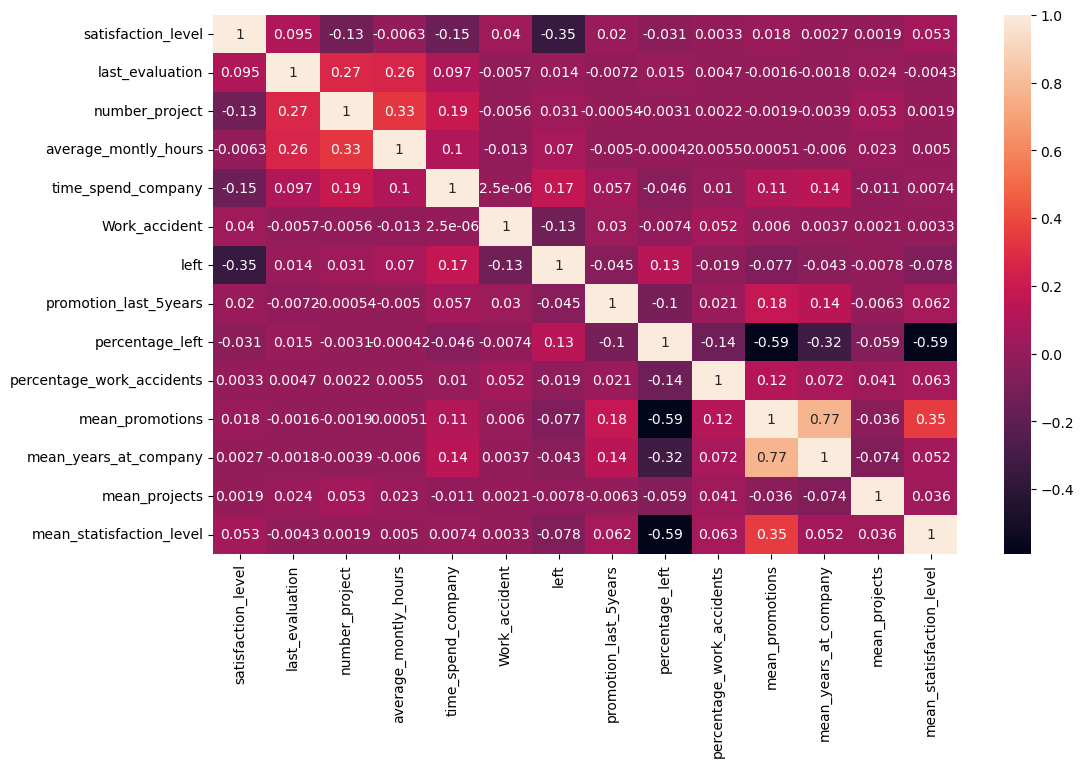

In [103]:
numeric_types = df.select_dtypes(exclude="object")

relations = numeric_types.corr()
plt.figure(figsize=(12, 7))
sns.heatmap(data=relations, annot=True)
plt.show()

#### Interpretation: This strong negative correlation suggests that as employee satisfaction increases, the percentage of employees who leave the company decreases. Conversely, lower satisfaction is associated with a higher percentage of employees leaving. This is a significant correlation indicating that employee satisfaction might be a key factor in employee retention.

# Prepare Column Transformer

In [104]:
categorical_types.drop("salary", axis=1, inplace=True)

In [108]:
preprocessor = create_column_transformer(categorical_types.columns, numeric_types.columns)
preprocessor

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['Department'], dtype='object')),
                                ('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('PowerTransformer',
                                                  PowerTransformer())]),
                                 Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'percentage_left', 'percentage_work_accidents',
       'mean_promotions', 'mean_years_at_company', 'mean_projects',
       'mean_statisfaction_level'],
      dtype='object'))])

# Separate Features

In [112]:
X = df.drop("salary", axis=1)
y = df["salary"]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# PCA Analysis

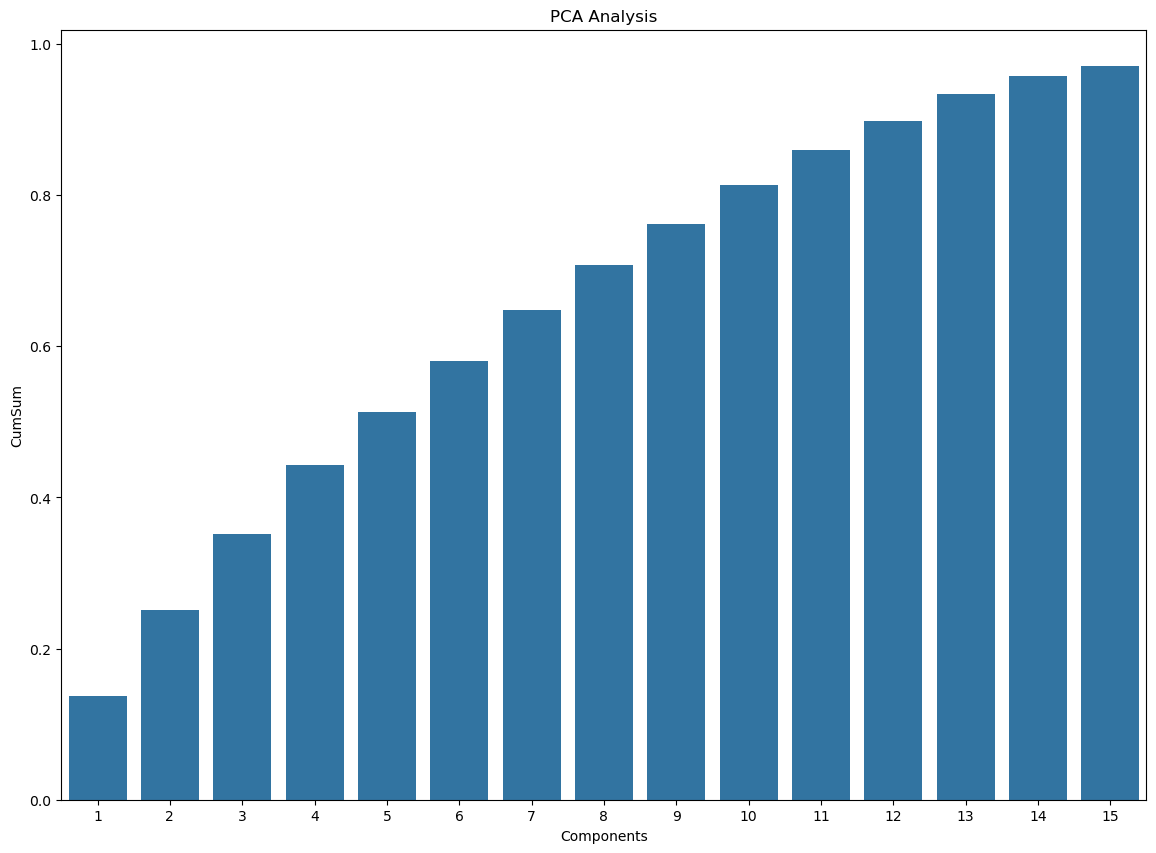

,Component,CumSum
0,1,0.136801
1,2,0.251397
2,3,0.351965
3,4,0.442320
4,5,0.513624
5,6,0.580929
6,7,0.647467
7,8,0.707733
8,9,0.761556
9,10,0.812844


In [113]:
pca_analysis(X, preprocessor)

# Create Metrics

In [121]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')

# Baseline Model